# Êñ∞ËÅûË≤ºÊñáÁóÖÊØíÂºèÂÇ≥Êí≠ÂàÜÊûê (News Viral Pattern Analysis)

Êú¨Á≠ÜË®òÊú¨Â∞áÂàÜÊûêMilvus‰∏≠ÁöÑÊñ∞ËÅûË≤ºÊñáÈõÜÂêàÔºåÊâæÂá∫ÁóÖÊØíÂºèÂÇ≥Êí≠ÁöÑÊ®°Âºè„ÄÇÊàëÂÄëÂ∞áÔºö
1. ÊØîËºÉÂêÑÁæ§ÈõÜÁöÑ count Âíå created_time ÂàÜÂ∏É
2. Ë≠òÂà•‰∏ÄÈñãÂßãÂ∞±ÁâπÂà•Ê¥ªË∫çÁöÑÁæ§ÈõÜÔºàÂèØËÉΩÊõ¥ÂÆπÊòìÁàÜÁ¥ÖÔºâ
3. ‰ΩøÁî® centroid_vector ÊâæÂá∫ËàáÂ∑≤Áü•ÁàÜÁ¥ÖÊñ∞ËÅûÁõ∏‰ººÁöÑÁæ§ÈõÜ‰∏ªÈ°å

In [2]:
# Â∞éÂÖ•ÊâÄÈúÄÁöÑÂ∫´
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pymilvus import connections, Collection
from sklearn.metrics.pairwise import cosine_similarity

# Ë®≠ÂÆö‰∏≠ÊñáÂ≠óÈ´îÊîØÊåÅÔºàÂ¶ÇÊûúÈúÄË¶ÅÔºâ
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# Ë®≠ÂÆöÁπ™ÂúñÈ¢®Ê†º
sns.set(style="whitegrid")

# Ë®≠ÂÆöÂúñÂΩ¢Â§ßÂ∞è
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [3]:
import wget

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont("ChineseFont.ttf")
mpl.rc('font', family="ChineseFont")

In [4]:
# ÈÄ£Êé•Âà∞ Milvus ÊúçÂãôÂô®
try:
    connections.connect(
        alias="default", 
        host="localhost",  # Ê†πÊìöÂØ¶ÈöõÊÉÖÊ≥Å‰øÆÊîπ
        port="19530"       # Ê†πÊìöÂØ¶ÈöõÊÉÖÊ≥Å‰øÆÊîπ
    )
    print("ÊàêÂäüÈÄ£Êé•Âà∞ Milvus ÊúçÂãôÂô®")
except Exception as e:
    print(f"ÈÄ£Êé• Milvus ÊúçÂãôÂô®ÊôÇÂá∫ÈåØ: {e}")

ÊàêÂäüÈÄ£Êé•Âà∞ Milvus ÊúçÂãôÂô®


In [5]:
# ËºâÂÖ• Milvus ÈõÜÂêà
try:
    # ËºâÂÖ•Êñ∞ËÅûË≤ºÊñáÈõÜÂêà
    news_posts = Collection("news_posts")
    news_posts.load()
    
    # ËºâÂÖ•Áæ§ÈõÜ‰∏≠ÂøÉÈõÜÂêà
    cluster_centroids = Collection("cluster_centroids")
    cluster_centroids.load()
    
    print("ÊàêÂäüËºâÂÖ• Milvus ÈõÜÂêà")
except Exception as e:
    print(f"ËºâÂÖ• Milvus ÈõÜÂêàÊôÇÂá∫ÈåØ: {e}")

ÊàêÂäüËºâÂÖ• Milvus ÈõÜÂêà


In [6]:
import time
import pandas as pd

# ÂÆöÁæ©Ëµ∑ÂßãÊó•ÊúüÂíåÁµêÊùüÊó•Êúü
start_date = "2021-01-01"
end_date = "2021-04-14"

# ÊääÊó•ÊúüÂ≠ó‰∏≤ËΩâÁÇ∫ timestamp
start_ts = 1609430400000000000
end_ts = 1618374574000000000

# ‰æùÂ§©Ëø≠‰ª£
one_day = 86400 * 1_000_000_000  # ‰∏ÄÂ§©ÁöÑÂ•àÁßíÊï∏
curr_ts = start_ts
all_days_posts = []
all_days_cluster = pd.DataFrame()

while curr_ts < end_ts:
    next_ts = curr_ts + one_day
    posts_query = news_posts.query(
        expr=f"created_time >= {curr_ts} and created_time < {next_ts}",
        output_fields=["id", "batch_cluster", "created_time", "is_early_report", "is_viral_event"],
        limit=1000
    )

    # Âæûposts_query‰∏≠Áç≤ÂèñÊâÄÊúâuniqueÁöÑbatch_cluster
    batch_clusters = []
    for post in posts_query:
        if 'batch_cluster' in post and post['batch_cluster'] not in batch_clusters:
            batch_clusters.append(post['batch_cluster'])
    
    # Â¶ÇÊûúÊúâÊâæÂà∞batch_clustersÔºåÊü•Ë©¢Â∞çÊáâÁöÑcluster_centroids
    if batch_clusters:
        # ÊßãÂª∫Êü•Ë©¢Ë°®ÈÅîÂºè‰æÜÂåπÈÖçÊâÄÊúâÁõ∏ÈóúÁöÑcluster_id
        expr = " or ".join([f"cluster_id == {cluster_id}" for cluster_id in batch_clusters])
        cluster_query = cluster_centroids.query(
            expr=expr,
            output_fields=["cluster_id", "centroid_vector", "count"],
            limit=len(batch_clusters)  # Âè™Áç≤ÂèñÂ∞çÊáâÁöÑÊï∏Èáè
        )
    else:
        # Â¶ÇÊûúÊ≤íÊúâÊâæÂà∞batch_clustersÔºåËøîÂõûÁ©∫ÂàóË°®
        cluster_query = []

    # ËΩâÊèõÁÇ∫ DataFrame
    cluster_df = pd.DataFrame(cluster_query)
    
    # Â∞áÁï∂Â§©ÁöÑclusterÊï∏ÊìöÊ∑ªÂä†Âà∞all_days_cluster
    if not cluster_df.empty:
        all_days_cluster = pd.concat([all_days_cluster, cluster_df], ignore_index=True)
    
    posts_df = pd.DataFrame(posts_query)
    posts_df['date'] = pd.to_datetime(posts_df['created_time'] // 1_000_000_000, unit='s').dt.date
    all_days_posts.append(posts_df)
    print(f"ÂÖ±Áç≤Âèñ {len(posts_df)} ÂÄãË≤ºÊñáÊï∏ÊìöÔºåÊó•ÊúüÁØÑÂúçÔºö{posts_df['date'].min()} ~ {posts_df['date'].max()}")
    print(posts_df['date'].head())
    curr_ts = next_ts  # <--- ÈÄô‰∏ÄË°åÁ¢∫‰øùÊØèÊ¨°Êü•Ë©¢‰∏çÂêåÂ§©

# Âêà‰ΩµÊâÄÊúâÂ§©ÁöÑË≥áÊñô
final_df = pd.concat(all_days_posts, ignore_index=True)
print(f"Á∏ΩÂÖ±ÊäìÂèñ {len(final_df)} Á≠ÜË≥áÊñôÔºåÊó•ÊúüÁØÑÂúçÔºö{final_df['date'].min()} ~ {final_df['date'].max()}")

ÂÖ±Áç≤Âèñ 1000 ÂÄãË≤ºÊñáÊï∏ÊìöÔºåÊó•ÊúüÁØÑÂúçÔºö2020-12-31 ~ 2021-01-01
0    2020-12-31
1    2020-12-31
2    2021-01-01
3    2021-01-01
4    2021-01-01
Name: date, dtype: object
ÂÖ±Áç≤Âèñ 1000 ÂÄãË≤ºÊñáÊï∏ÊìöÔºåÊó•ÊúüÁØÑÂúçÔºö2021-01-01 ~ 2021-01-02
0    2021-01-02
1    2021-01-02
2    2021-01-02
3    2021-01-02
4    2021-01-02
Name: date, dtype: object
ÂÖ±Áç≤Âèñ 1000 ÂÄãË≤ºÊñáÊï∏ÊìöÔºåÊó•ÊúüÁØÑÂúçÔºö2021-01-02 ~ 2021-01-03
0    2021-01-03
1    2021-01-03
2    2021-01-03
3    2021-01-03
4    2021-01-03
Name: date, dtype: object
ÂÖ±Áç≤Âèñ 1000 ÂÄãË≤ºÊñáÊï∏ÊìöÔºåÊó•ÊúüÁØÑÂúçÔºö2021-01-03 ~ 2021-01-04
0    2021-01-04
1    2021-01-04
2    2021-01-04
3    2021-01-04
4    2021-01-04
Name: date, dtype: object
ÂÖ±Áç≤Âèñ 1000 ÂÄãË≤ºÊñáÊï∏ÊìöÔºåÊó•ÊúüÁØÑÂúçÔºö2021-01-04 ~ 2021-01-05
0    2021-01-04
1    2021-01-05
2    2021-01-05
3    2021-01-04
4    2021-01-04
Name: date, dtype: object
ÂÖ±Áç≤Âèñ 1000 ÂÄãË≤ºÊñáÊï∏ÊìöÔºåÊó•ÊúüÁØÑÂúçÔºö2021-01-05 ~ 2021-01-06
0    2021-01-05
1    2021-01-05
2    2

Á∏ΩÂÖ±Êúâ 105 ÂÄã‰∏çÂêåÊó•Êúü
ÊôÇÈñìÁØÑÂúç: 2020-12-31 Âà∞ 2021-04-14
2020-12-31: ÊäΩÂèñ‰∫Ü 619 ÂâáË®òÈåÑ (ÂÖ± 619 Ââá)
2021-01-01: ÊäΩÂèñ‰∫Ü 384 ÂâáË®òÈåÑ (ÂÖ± 384 Ââá)
2021-01-02: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1098 Ââá)
2021-01-03: ÊäΩÂèñ‰∫Ü 928 ÂâáË®òÈåÑ (ÂÖ± 928 Ââá)
2021-01-04: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1014 Ââá)
2021-01-05: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1053 Ââá)
2021-01-06: ÊäΩÂèñ‰∫Ü 921 ÂâáË®òÈåÑ (ÂÖ± 921 Ââá)
2021-01-07: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1030 Ââá)
2021-01-08: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1103 Ââá)
2021-01-09: ÊäΩÂèñ‰∫Ü 897 ÂâáË®òÈåÑ (ÂÖ± 897 Ââá)
2021-01-10: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1021 Ââá)
2021-01-11: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1008 Ââá)
2021-01-12: ÊäΩÂèñ‰∫Ü 993 ÂâáË®òÈåÑ (ÂÖ± 993 Ââá)
2021-01-13: ÊäΩÂèñ‰∫Ü 939 ÂâáË®òÈåÑ (ÂÖ± 939 Ââá)
2021-01-14: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1018 Ââá)
2021-01-15: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1027 Ââá)
2021-01-16: ÊäΩÂèñ‰∫Ü 998 ÂâáË®òÈåÑ (ÂÖ± 998 Ââá)
2021-01-17: ÊäΩÂèñ‰∫Ü 1000 ÂâáË®òÈåÑ (ÂÖ± 1143 Ââá)
2021-01-18

batch_cluster  cluster_id  count
0               0           0      1
1               1           1      1
2             831         831      1
3             771         771      1
4             278         278      1
5             680         680      1
6             619         619      1
7             602         602      1
8             234         234      1
9             213         213      1
10            236         236      1
11            140         140      3
12            377         377      1
13            949         949      1
14            957         957      1
15            897         897      1
16            923         923      1
17            719         719      1
18            119         119      8
19           1015        1015      1


ÂåπÈÖçÊàêÂäüÁéá: 100.00% (93658/93658)

ÊØèÊó•Ê®£Êú¨ËàáÂ∞çÊáâÁöÑcluster_id:


id  batch_cluster         created_time  is_early_report  is_viral_event  \
0   19              0  1609430400000000000             True           False   
1   57              1  1609430400000000000             True           False   
2  128            831  1609449106000000000             True           False   
3  129            771  1609446450000000000             True           False   
4  130            278  1609432230000000000             True           False   

         date  cluster_id  
0  2020-12-31           0  
1  2020-12-31           1  
2  2020-12-31         831  
3  2020-12-31         771  
4  2020-12-31         278


ÊØèÂ§©‰∏çÂêåÁæ§ÈõÜÁöÑÊï∏ÈáèÂàÜÂ∏É:


date  cluster_id  count
0   2020-12-31           0      1
1   2020-12-31           1      1
2   2020-12-31           2      1
3   2020-12-31           3      1
4   2020-12-31           4      1
5   2020-12-31           5      1
6   2020-12-31           6      1
7   2020-12-31           7      1
8   2020-12-31           8      1
9   2020-12-31           9      1
10  2020-12-31          10      1
11  2020-12-31          11      1
12  2020-12-31          14      2
13  2020-12-31          15      1
14  2020-12-31          16      1
15  2020-12-31          17      1
16  2020-12-31          18      1
17  2020-12-31          20      1
18  2020-12-31          38      1
19  2020-12-31          40      1

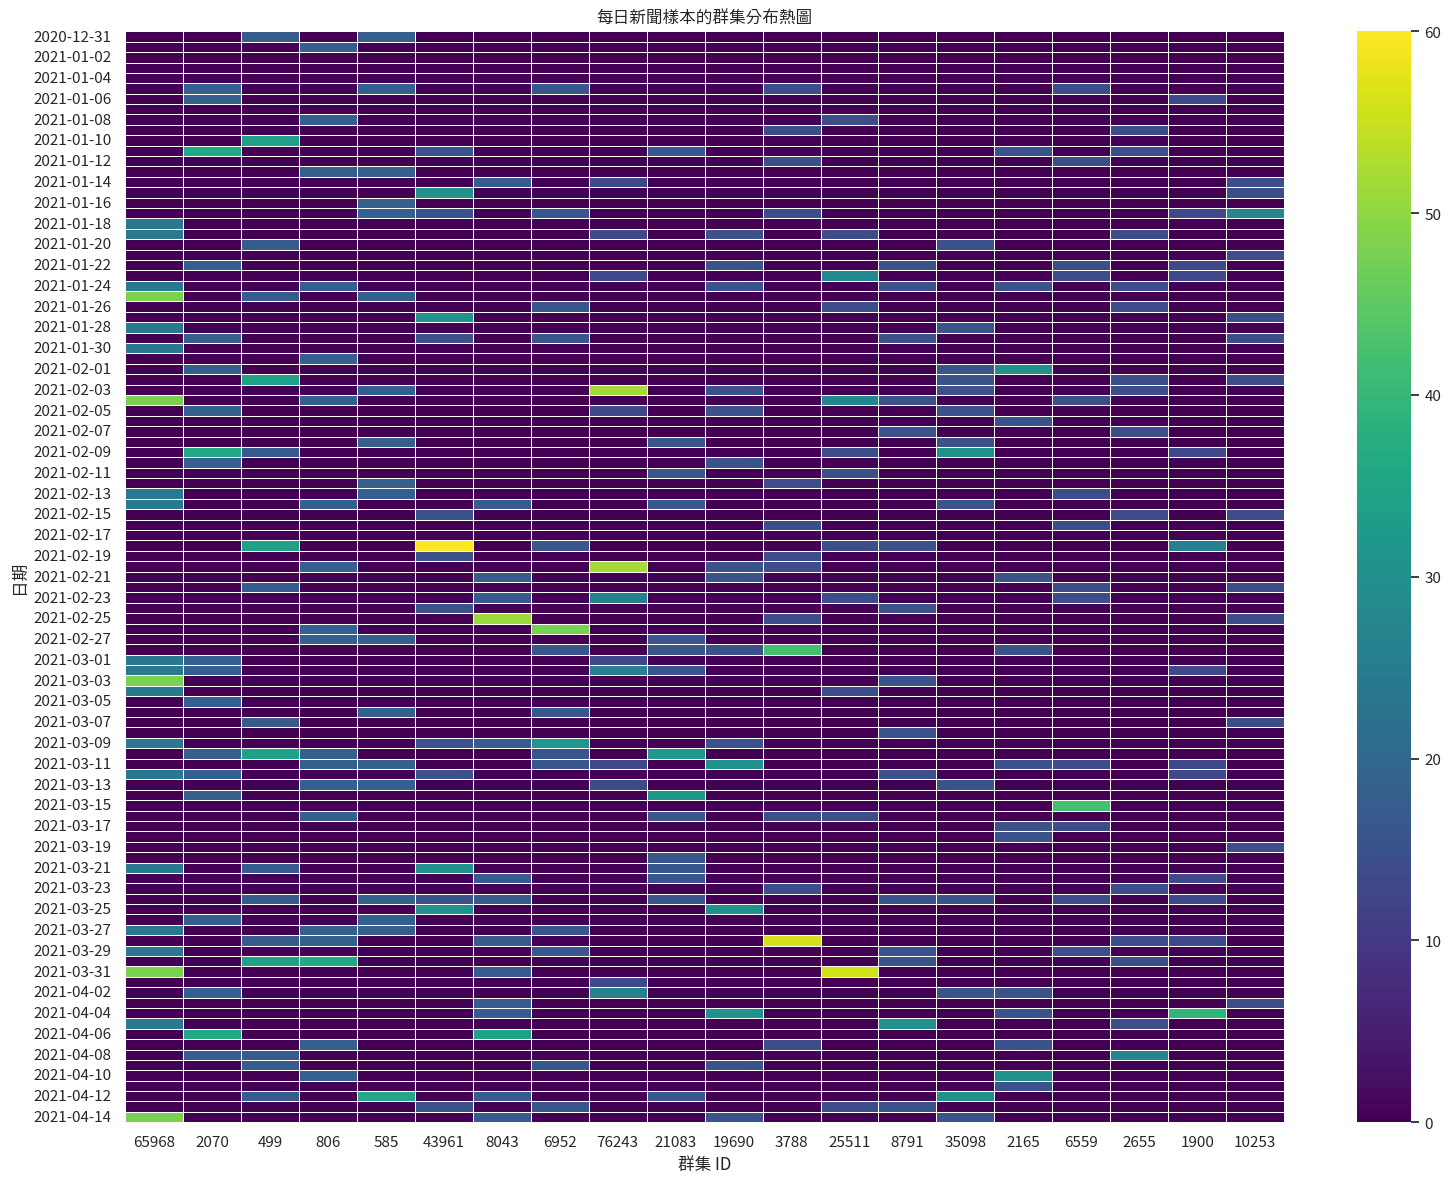


Áæ§ÈõÜÊ¥ªË∫çÊôÇÈñìÁµ±Ë®àÔºàÊåâË≤ºÊñáÊï∏ÈáèÊéíÂ∫èÔºâ:


cluster_id first_date  last_date  post_count  active_days
7211       65968 2021-01-18 2021-04-14         624           87
641         2070 2021-01-05 2021-04-08         396           94
224          499 2020-12-31 2021-04-12         374          103
351          806 2021-01-01 2021-04-10         360          100
255          585 2020-12-31 2021-04-12         342          103
5216       43961 2021-01-11 2021-04-13         330           93
1051        8043 2021-01-14 2021-04-14         306           91
986         6952 2021-01-05 2021-04-13         288           99
8225       76243 2021-01-14 2021-04-02         286           79
2726       21083 2021-01-11 2021-04-12         272           92
2548       19690 2021-01-19 2021-04-14         270           86
772         3788 2021-01-05 2021-04-07         266           93
3324       25511 2021-01-08 2021-04-13         252           96
1101        8791 2021-01-22 2021-04-13         240           82
4293       35098 2021-01-20 2021-04-14         240           85
649         2165 2021-01-11 2021-04-11         240           91
954         6559 2021-01-05 2021-03-29         224           84
685         2655 2021-01-09 2021-04-08         210           90
623         1900 2021-01-06 2021-04-04         208           89
1204       10253 2021-01-14 2021-04-03         196           80


ÁµêÊûúÂ∑≤‰øùÂ≠òËá≥: daily_sampled_news_with_clusters.csv

ÊØèÊó•Ê®£Êú¨ÂàÜÊûêÂÆåÊàêÔºÅ


In [7]:
# Ê†πÊìö created_time ÊØèÂ§©ÊèêÂèñ 1000 Á≠ÜË®òÈåÑ‰∏¶Â∞ãÊâæÂ∞çÊáâÁöÑ cluster_id
try:
    
    # Áç≤ÂèñÊâÄÊúâ‰∏çÂêåÊó•Êúü
    unique_dates = sorted(final_df['date'].unique())
    print(f"Á∏ΩÂÖ±Êúâ {len(unique_dates)} ÂÄã‰∏çÂêåÊó•Êúü")
    print(f"ÊôÇÈñìÁØÑÂúç: {min(unique_dates)} Âà∞ {max(unique_dates)}")
    
    # Âª∫Á´ã‰∏ÄÂÄãÁ©∫ÁöÑDataFrame‰æÜÂ≠òÂÑ≤ÊØèÂ§©ÁöÑ1000ÂâáË®òÈåÑ
    daily_samples = []
    
    for date in unique_dates:
        # ÁØ©ÈÅ∏Áï∂Â§©ÁöÑË®òÈåÑ
        day_posts = final_df[final_df['date'] == date]
        
        # Â¶ÇÊûúÁï∂Â§©Ë®òÈåÑÊï∏Ë∂ÖÈÅé1000ÔºåÈö®Ê©üÊäΩÂèñ1000Ê¢ù
        if len(day_posts) > 1000:
            sampled_posts = day_posts.sample(n=1000, random_state=42)
        else:
            sampled_posts = day_posts  # Â¶ÇÊûúÂ∞ëÊñº1000Ê¢ùÔºåÂÖ®ÈÉ®ÂèñÁî®
        
        daily_samples.append(sampled_posts)
        print(f"{date}: ÊäΩÂèñ‰∫Ü {len(sampled_posts)} ÂâáË®òÈåÑ (ÂÖ± {len(day_posts)} Ââá)")
    
    # Âêà‰ΩµÊâÄÊúâÊØèÊó•Ê®£Êú¨
    daily_sampled_df = pd.concat(daily_samples, ignore_index=True)
    print(f"\nÁ∏ΩÂÖ±ÊäΩÂèñ‰∫Ü {len(daily_sampled_df)} ÂâáË®òÈåÑ")
    
    # Áç≤ÂèñÈÄô‰∫õÊ®£Êú¨ÊâÄÂ±¨ÁöÑÊâπÊ¨°Áæ§ÈõÜID
    unique_batch_clusters = daily_sampled_df['batch_cluster'].unique()
    print(f"ÈÄô‰∫õË®òÈåÑÂ±¨Êñº {len(unique_batch_clusters)} ÂÄã‰∏çÂêåÁöÑÊâπÊ¨°Áæ§ÈõÜ")
    
    # Âú®cluster_centroids‰∏≠ÊâæÂá∫Â∞çÊáâÁöÑcluster_id
    matched_clusters = []
    for batch_id in unique_batch_clusters:
        # Âú®cluster_centroids‰∏≠Êü•Ë©¢
        cluster_matches = all_days_cluster[all_days_cluster['cluster_id'] == batch_id]
        
        if not cluster_matches.empty:
            for _, cluster_row in cluster_matches.iterrows():
                matched_clusters.append({
                    'batch_cluster': batch_id,
                    'cluster_id': cluster_row['cluster_id'],
                    'count': cluster_row['count']
                })
        else:
            # Êâæ‰∏çÂà∞Â∞çÊáâcluster_idÁöÑÊÉÖÊ≥Å
            matched_clusters.append({
                'batch_cluster': batch_id,
                'cluster_id': None,
                'count': 0
            })
    
    # ËΩâÊèõÁÇ∫DataFrame
    matched_clusters_df = pd.DataFrame(matched_clusters)
    
    # È°ØÁ§∫ÂåπÈÖçÁµêÊûú
    print("\nÊâπÊ¨°Áæ§ÈõÜËàáÈõÜ‰∏≠Áæ§ÈõÜÁöÑÂåπÈÖçÁµêÊûúÔºö")
    display(matched_clusters_df.head(20))
    
    # Ë®àÁÆóÂåπÈÖçÊàêÂäüÁéá
    match_success = matched_clusters_df['cluster_id'].notna().sum()
    match_rate = match_success / len(matched_clusters_df) * 100
    print(f"\nÂåπÈÖçÊàêÂäüÁéá: {match_rate:.2f}% ({match_success}/{len(matched_clusters_df)})")
    
    # Â∞áÂåπÈÖçÁµêÊûúÂêà‰ΩµÂà∞ÂéüÂßãÁöÑÊØèÊó•Ê®£Êú¨‰∏≠
    result_df = pd.merge(
        daily_sampled_df,
        matched_clusters_df[['batch_cluster', 'cluster_id']],
        on='batch_cluster',
        how='left'
    )
    
    # È°ØÁ§∫ÊúÄÁµÇÁµêÊûú
    print("\nÊØèÊó•Ê®£Êú¨ËàáÂ∞çÊáâÁöÑcluster_id:")
    display(result_df.head())
    
    # Ê†πÊìöÊó•ÊúüÂàÜÁµÑ‰∏¶Ë®àÁÆóÁæ§ÈõÜÂàÜÂ∏É
    cluster_date_counts = result_df.groupby(['date', 'cluster_id']).size().reset_index(name='count')
    print("\nÊØèÂ§©‰∏çÂêåÁæ§ÈõÜÁöÑÊï∏ÈáèÂàÜÂ∏É:")
    display(cluster_date_counts.head(20))
    
    # Áπ™Ë£ΩÁÜ±ÂúñÈ°ØÁ§∫ÊØèÊó•ÁöÑÁæ§ÈõÜÂàÜÂ∏ÉÊÉÖÊ≥Å
    try:
        # ÂèñÂâç20ÂÄãÊúÄÂ∏∏Ë¶ãÁöÑÁæ§ÈõÜ
        top_clusters = result_df['cluster_id'].value_counts().nlargest(20).index.tolist()
        
        # ÂâµÂª∫ÈÄèË¶ñË°®
        date_cluster_pivot = pd.pivot_table(
            cluster_date_counts, 
            values='count', 
            index='date', 
            columns='cluster_id',
            fill_value=0
        )
        
        # ÂèñÂæóÂèØÁî®ÁöÑÁæ§ÈõÜ
        available_clusters = [c for c in top_clusters if c in date_cluster_pivot.columns]
        
        if available_clusters:
            plt.figure(figsize=(16, 12))
            sns.heatmap(
                date_cluster_pivot[available_clusters],
                cmap='viridis',
                annot=False,
                fmt='g',
                linewidths=.5
            )
            plt.title('ÊØèÊó•Êñ∞ËÅûÊ®£Êú¨ÁöÑÁæ§ÈõÜÂàÜÂ∏ÉÁÜ±Âúñ')
            plt.xlabel('Áæ§ÈõÜ ID')
            plt.ylabel('Êó•Êúü')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Áπ™Ë£ΩÁÜ±ÂúñÊôÇÂá∫ÈåØ: {e}")
    
    # ÂàÜÊûêÂêÑÁæ§ÈõÜÁöÑÊôÇÈñìË∑®Â∫¶
    # ÂÖàÂ∞áÊó•ÊúüËΩâÊèõÁÇ∫datetimeÊ†ºÂºè
    result_df['date'] = pd.to_datetime(result_df['date'])
    
    cluster_activity = result_df.groupby('cluster_id').agg(
        first_date=('date', 'min'),
        last_date=('date', 'max'),
        post_count=('id', 'count')
    ).reset_index()
    
    # Ë®àÁÆóÊ¥ªË∫çÂ§©Êï∏
    cluster_activity['active_days'] = (cluster_activity['last_date'] - cluster_activity['first_date']).dt.days + 1
    
    # Ê†πÊìöË≤ºÊñáÊï∏ÈáèÊéíÂ∫è
    cluster_activity = cluster_activity.sort_values(by='post_count', ascending=False)
    
    print("\nÁæ§ÈõÜÊ¥ªË∫çÊôÇÈñìÁµ±Ë®àÔºàÊåâË≤ºÊñáÊï∏ÈáèÊéíÂ∫èÔºâ:")
    display(cluster_activity.head(20))
    
    # ‰øùÂ≠òÁµêÊûú
    result_path = 'daily_sampled_news_with_clusters.csv'
    result_df.to_csv(result_path, index=False)
    print(f"\nÁµêÊûúÂ∑≤‰øùÂ≠òËá≥: {result_path}")
    
    print("\nÊØèÊó•Ê®£Êú¨ÂàÜÊûêÂÆåÊàêÔºÅ")
    
except Exception as e:
    print(f"ËôïÁêÜÊØèÊó•Ê®£Êú¨ÊôÇÂá∫ÈåØ: {e}")
    import traceback
    traceback.print_exc()

In [12]:
import traceback
import mysql.connector
from mysql.connector import Error
import pandas as pd

# ÂàÜÊûêÁæ§ÈõÜÊ¥ªÂãïÊ®°ÂºèÂíåÊâæÂá∫ÊΩõÂú®ÁöÑÁóÖÊØíÂºèÂÇ≥Êí≠Ê®°Âºè
print("=== ÂàÜÊûêÊñ∞ËÅûÁæ§ÈõÜÂÇ≥Êí≠Ê®°Âºè ===")

# 1. ÂàÜÊûê cluster_activity ‰∏≠ÁöÑÂàÜÂ∏ÉÊÉÖÊ≥Å
print("\nÁæ§ÈõÜÊ¥ªË∫çÂ∫¶ÂàÜÂ∏ÉÊÉÖÊ≥Å:")
print(f"Á∏ΩÁæ§ÈõÜÊï∏: {len(cluster_activity)}")
print(f"Âπ≥ÂùáË≤ºÊñáÊï∏: {cluster_activity['post_count'].mean():.2f}")
print(f"Âπ≥ÂùáÊ¥ªË∫çÂ§©Êï∏: {cluster_activity['active_days'].mean():.2f}")

# 2. ÁØ©ÈÅ∏Âá∫Ë≤ºÊñáÊï∏Âú® 2-21 ‰πãÈñìÁöÑÁæ§ÈõÜÈÄ≤Ë°åË©≥Á¥∞ÂàÜÊûê
filtered_clusters = cluster_activity[(cluster_activity['post_count'] >= 2) & (cluster_activity['post_count'] <= 100)]
print(f"ÁØ©ÈÅ∏Âá∫ {len(filtered_clusters)} ÂÄãË≤ºÊñáÊï∏Âú® 2-21 ‰πãÈñìÁöÑÁæ§ÈõÜ")

# 3. Êü•Ë©¢MySQLÁç≤ÂèñÂ∞çÊáâÊñ∞ËÅûÁöÑÊõ¥Â§öÁâπÂæµ‰∏¶Ëàácluster_activityÂêà‰Ωµ
try:
    print("\nÂòóË©¶ÂæûMySQLÁç≤ÂèñÊõ¥Â§öÁâπÂæµ‰∏¶Âêà‰ΩµÊï∏Êìö...")
    
    def get_mysql_connection():
        try:
            connection = mysql.connector.connect(
                host='localhost',
                user='root',
                password='12345678',
                database='fbarticle'
            )
            print("MySQL Database connection successful")
            return connection
        except Error as e:
            print(f"Error connecting to MySQL Database: {e}")
            return None
    
    conn = get_mysql_connection()
    if conn is None:
        raise Exception("ÁÑ°Ê≥ïÈÄ£Êé•Âà∞MySQLË≥áÊñôÂ∫´")
    
    cursor = conn.cursor()
    
    # Áç≤ÂèñÊâÄÊúâÈúÄË¶ÅÁöÑcluster_idÂàóË°®
    cluster_ids = filtered_clusters['cluster_id'].tolist()
    
    # Êü•Ë©¢MySQL‰∏≠Â∞çÊáâÁöÑË®òÈåÑ
    query = f"""
        SELECT id, created_time, reaction_all, comment_count, share_count, 
               date, page_category, page_name, content
        FROM news_posts
        WHERE id IN ({','.join(map(str, cluster_ids))})
    """
    
    cursor.execute(query)
    news_details = cursor.fetchall()
    
    print(f"ÂæûMySQLÊü•Ë©¢Âà∞ {len(news_details)} Ê¢ùË®òÈåÑ")
    
    # Â∞áÊü•Ë©¢ÁµêÊûúËΩâÊèõÁÇ∫DataFrame
    mysql_df = pd.DataFrame(news_details, columns=[
        'id', 'created_time', 'reaction_all', 'comment_count', 'share_count',
        'date', 'page_category', 'page_name', 'content'
    ])
    
    # ÈáçÂëΩÂêçbatch_clusterÁÇ∫cluster_id‰ª•‰æøÂêà‰Ωµ
    mysql_df = mysql_df.rename(columns={'id': 'cluster_id'})
    
    # Â∞ácluster_activityËàámysqlÊï∏ÊìöÂêà‰Ωµ
    # ÊñπÊ≥ï1: Â∞ácluster_activityÁöÑÁµ±Ë®à‰ø°ÊÅØÂä†Âà∞ÊØèÂÄãÊñ∞ËÅûË®òÈåÑ‰∏ä
    merged_data = pd.merge(
        mysql_df,
        filtered_clusters,
        on='cluster_id',
        how='inner'
    )
    
    print(f"Âêà‰ΩµÂæåÁöÑÊï∏ÊìöÈõÜÂåÖÂê´ {len(merged_data)} Ê¢ùË®òÈåÑ")
    print(f"Ê∂µËìã {merged_data['cluster_id'].nunique()} ÂÄã‰∏çÂêåÁöÑÁæ§ÈõÜ")
    
    # È°ØÁ§∫Âêà‰ΩµÂæåÊï∏ÊìöÁöÑÂü∫Êú¨‰ø°ÊÅØ
    print("\nÂêà‰ΩµÂæåÊï∏ÊìöÈõÜÁöÑÂü∫Êú¨‰ø°ÊÅØ:")
    print(f"ÂàóÊï∏: {len(merged_data.columns)}")
    print(f"Ë°åÊï∏: {len(merged_data)}")
    print("\nÂêÑÂàóÂêçÁ®±:")
    for i, col in enumerate(merged_data.columns, 1):
        print(f"{i:2d}. {col}")
    
    # È°ØÁ§∫ÂâçÂπæË°åÊï∏ÊìöÊ®£Êú¨
    print("\nÊï∏ÊìöÊ®£Êú¨ (Ââç3Ë°å):")
    display_columns = ['cluster_id', 'post_count', 'active_days', 'page_name', 'reaction_all']
    print(merged_data[display_columns].head(3))
    
    # ÈóúÈñâÈÄ£Êé•
    cursor.close()
    conn.close()
    
    print(f"\n‚úÖ Êï∏ÊìöÂêà‰ΩµÂÆåÊàêÔºÅÂêà‰ΩµÂæåÁöÑÊï∏ÊìöÂ≠òÂÑ≤Âú® 'merged_data' ËÆäÈáè‰∏≠")
    print("ÈÄôÂÄãÊï∏ÊìöÈõÜÂåÖÂê´‰∫Ü:")
    print("- MySQL‰∏≠ÁöÑÊñ∞ËÅûË©≥Á¥∞‰ø°ÊÅØ (id, created_time, reaction_all, etc.)")
    print("- cluster_activity‰∏≠ÁöÑÁæ§ÈõÜÁµ±Ë®à‰ø°ÊÅØ (post_count, active_days, etc.)")
    print("- ÂèØ‰ª•Áî®ÊñºÂæåÁ∫åÁöÑÁâπÂæµÂ∑•Á®ãÂíåÈ†êÊ∏¨Ê®°ÂûãË®ìÁ∑¥")

except Exception as e:
    print(f"Áç≤ÂèñMySQLÊï∏ÊìöÊôÇÂá∫ÈåØ: {e}")
    traceback.print_exc()

# ÂèØÈÅ∏: ‰øùÂ≠òÂêà‰ΩµÂæåÁöÑÊï∏ÊìöÂà∞CSVÊñá‰ª∂
try:
    merged_data.to_csv('merged_cluster_news_data.csv', index=False, encoding='utf-8')
    print(f"\nüìÑ Âêà‰ΩµÂæåÁöÑÊï∏ÊìöÂ∑≤‰øùÂ≠òÂà∞ 'merged_cluster_news_data.csv'")
except:
    print("\n‚ö†Ô∏è  ‰øùÂ≠òCSVÊñá‰ª∂ÊôÇÂá∫ÁèæÂïèÈ°åÔºå‰ΩÜÊï∏ÊìöÂêà‰Ωµ‰ªçÁÑ∂ÊàêÂäü")

=== ÂàÜÊûêÊñ∞ËÅûÁæ§ÈõÜÂÇ≥Êí≠Ê®°Âºè ===

Áæ§ÈõÜÊ¥ªË∫çÂ∫¶ÂàÜÂ∏ÉÊÉÖÊ≥Å:
Á∏ΩÁæ§ÈõÜÊï∏: 88142
Âπ≥ÂùáË≤ºÊñáÊï∏: 1.68
Âπ≥ÂùáÊ¥ªË∫çÂ§©Êï∏: 1.79
ÁØ©ÈÅ∏Âá∫ 4384 ÂÄãË≤ºÊñáÊï∏Âú® 2-21 ‰πãÈñìÁöÑÁæ§ÈõÜ

ÂòóË©¶ÂæûMySQLÁç≤ÂèñÊõ¥Â§öÁâπÂæµ‰∏¶Âêà‰ΩµÊï∏Êìö...
MySQL Database connection successful
ÂæûMySQLÊü•Ë©¢Âà∞ 400 Ê¢ùË®òÈåÑ
Âêà‰ΩµÂæåÁöÑÊï∏ÊìöÈõÜÂåÖÂê´ 400 Ê¢ùË®òÈåÑ
Ê∂µËìã 400 ÂÄã‰∏çÂêåÁöÑÁæ§ÈõÜ

Âêà‰ΩµÂæåÊï∏ÊìöÈõÜÁöÑÂü∫Êú¨‰ø°ÊÅØ:
ÂàóÊï∏: 13
Ë°åÊï∏: 400

ÂêÑÂàóÂêçÁ®±:
 1. cluster_id
 2. created_time
 3. reaction_all
 4. comment_count
 5. share_count
 6. date
 7. page_category
 8. page_name
 9. content
10. first_date
11. last_date
12. post_count
13. active_days

Êï∏ÊìöÊ®£Êú¨ (Ââç3Ë°å):
   cluster_id  post_count  active_days          page_name  reaction_all
0         130           4            1     TVBS ÁæéÂúãÁâπÊ¥æÂì° ÂÄ™ÂòâÂæΩ            16
1         224           2            1  Ê≠£Â¶πËÅØÁõü BeautyLeague             1
2        1315          36           88                È¢®ÁîüÊ¥ª             1

‚úÖ Ê

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\king2\AppData\Local\Temp\jieba.cache


=== ÊñáÁ´†ÁàÜÁ¥ÖÈ†êÊ∏¨ËàáÈóúÈçµÂ≠óÂàÜÊûêÊ®°Âûã ===

ËºâÂÖ•Êï∏Êìö‰∏¶ÈÄ≤Ë°åÁâπÂæµÂ∑•Á®ã...
ÈÄ≤Ë°åÊñáÊú¨ÁâπÂæµÊèêÂèñ...


Loading model cost 0.529 seconds.
Prefix dict has been built successfully.


Â∞á‰∫íÂãïÁ∏ΩÈáèË∂ÖÈÅé 19.00 ÁöÑÊñáÁ´†ÂÆöÁæ©ÁÇ∫ÁàÜÁ¥Ö
ÁàÜÁ¥ÖÊñáÁ´†Êï∏: 184 (‰ΩîÊØî 18.40%)

ÁàÜÁ¥ÖËàáÈùûÁàÜÁ¥ÖÊñáÁ´†ÁöÑÁâπÂæµÂ∑ÆÁï∞:
post_count: ÁàÜÁ¥Ö 26.73 vs ÈùûÁàÜÁ¥Ö 27.23 (Â∑ÆÁï∞ -1.84%)
active_days: ÁàÜÁ¥Ö 74.82 vs ÈùûÁàÜÁ¥Ö 73.55 (Â∑ÆÁï∞ 1.73%)
posts_per_day: ÁàÜÁ¥Ö 0.43 vs ÈùûÁàÜÁ¥Ö 0.43 (Â∑ÆÁï∞ -0.59%)
activity_intensity: ÁàÜÁ¥Ö 0.33 vs ÈùûÁàÜÁ¥Ö 0.21 (Â∑ÆÁï∞ 51.84%)
engagement_per_post: ÁàÜÁ¥Ö 1.16 vs ÈùûÁàÜÁ¥Ö 0.73 (Â∑ÆÁï∞ 60.33%)
content_length: ÁàÜÁ¥Ö 15.84 vs ÈùûÁàÜÁ¥Ö 15.96 (Â∑ÆÁï∞ -0.78%)
hashtag_count: ÁàÜÁ¥Ö 2.00 vs ÈùûÁàÜÁ¥Ö 2.00 (Â∑ÆÁï∞ 0.00%)

=== ÁàÜÁ¥ÖÊñáÁ´†ÈóúÈçµÂ≠óÂàÜÊûê ===
ÁàÜÁ¥ÖÊñáÁ´†ÈóúÈçµÂ≠ó (Ââç10ÂÄã):

=== Âª∫Á´ãÈ†êÊ∏¨Ê®°Âûã ===
Ë®ìÁ∑¥ÈõÜÊ∫ñÁ¢∫Áéá: 1.0000
Ê∏¨Ë©¶ÈõÜÊ∫ñÁ¢∫Áéá: 0.8650

ÂàÜÈ°ûÂ†±Âëä:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       163
           1       0.71      0.46      0.56        37

    accuracy                           0.86       200
   macro avg       0.80      0.71      0.74 

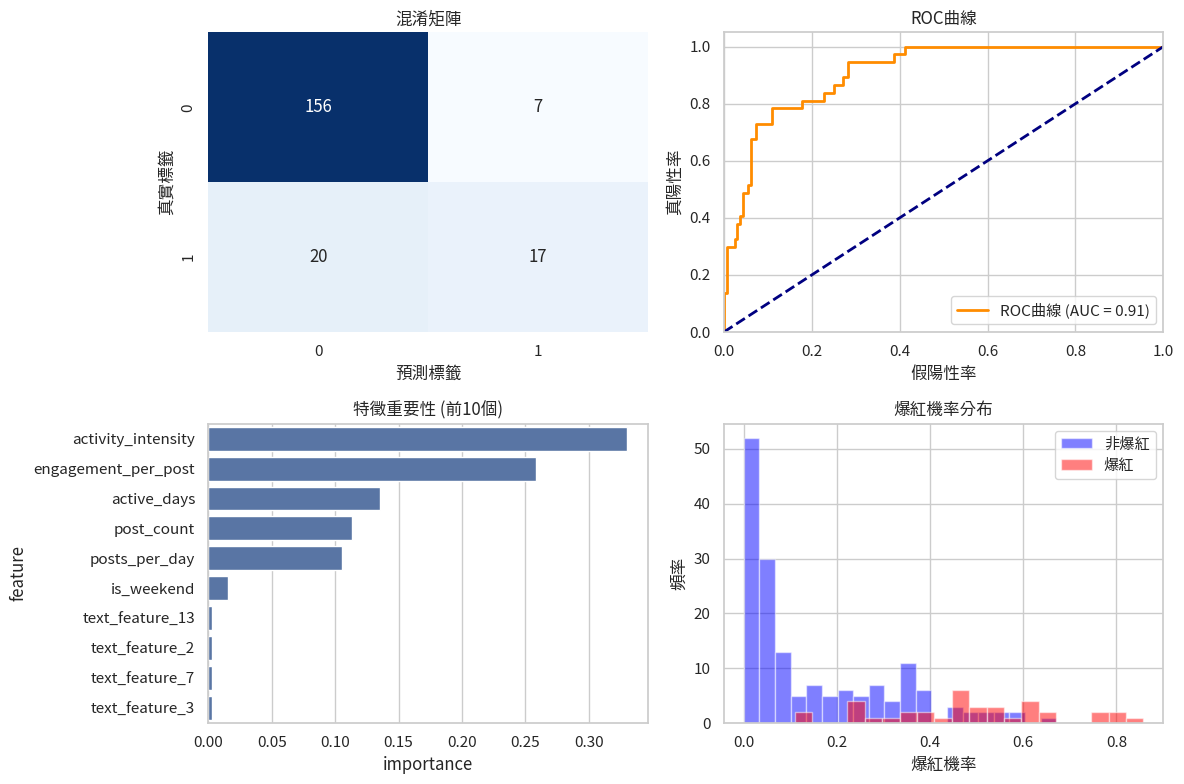


=== ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéáÈ†êÊ∏¨Á§∫‰æã ===
ÊñáÁ´† 1: ÈáçÂ§ßÁ™ÅÁôºÊñ∞ËÅûÔºÅÊòéÊòüÁ∑ãËÅûÁàÜÂá∫È©ö‰∫∫ÂÖßÂπï #Â®õÊ®Ç #ÁàÜÊñô #ÁÜ±ÈñÄ...
ÁàÜÁ¥ÖÊ©üÁéá: 66.20%
È†êÊ∏¨ÁµêÊûú: ÂèØËÉΩÁàÜÁ¥Ö

ÊñáÁ´† 2: ‰ªäÂ§©Â§©Ê∞£ÂæàÂ•ΩÔºåÈÅ©ÂêàÂá∫ÈñÄËµ∞Ëµ∞...
ÁàÜÁ¥ÖÊ©üÁéá: 69.69%
È†êÊ∏¨ÁµêÊûú: ÂèØËÉΩÁàÜÁ¥Ö

ÊñáÁ´† 3: „ÄêÁç®ÂÆ∂„ÄëÊîøÊ≤ª‰∫∫Áâ©ÈáçÂ§ßÈÜúËÅûÊõùÂÖâÔºÅÈúáÈ©öÂÖ®Âúã #ÊîøÊ≤ª #Áç®ÂÆ∂ #Èáç...
ÁàÜÁ¥ÖÊ©üÁéá: 75.77%
È†êÊ∏¨ÁµêÊûú: ÂèØËÉΩÁàÜÁ¥Ö

=== ÂàÜÊûêÂÆåÊàê ===
Ê≠§Ê®°ÂûãÂèØ‰ª•Âπ´Âä©:
1. È†êÊ∏¨ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéá
2. Ë≠òÂà•ÁàÜÁ¥ÖÈóúÈçµÂ≠ó
3. ÂÑ™ÂåñÂÖßÂÆπÁ≠ñÁï•
4. ÊèêÂçáÊñáÁ´†‰∫íÂãïÁéá


c:\Users\king2\anaconda3\envs\SQL\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\king2\anaconda3\envs\SQL\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\king2\anaconda3\envs\SQL\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import jieba
from collections import Counter

# Ë®≠ÁΩÆ‰∏≠ÊñáÂ≠óÈ´î
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("=== ÊñáÁ´†ÁàÜÁ¥ÖÈ†êÊ∏¨ËàáÈóúÈçµÂ≠óÂàÜÊûêÊ®°Âûã ===\n")

# 1. ÊñáÊú¨È†êËôïÁêÜÂáΩÊï∏
def preprocess_text(text):
    """ÊñáÊú¨È†êËôïÁêÜÔºöÊ∏ÖÁêÜÂíåÂàÜË©û"""
    if pd.isna(text):
        return ""
    
    # ÁßªÈô§ÁâπÊÆäÁ¨¶ËôüÂíåÁ∂≤ÂùÄ
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[^\w\s#@]', ' ', text)
    
    # ‰ΩøÁî®jiebaÂàÜË©û
    words = jieba.cut(text)
    # ÈÅéÊøæÊéâÈï∑Â∫¶Â∞èÊñº2ÁöÑË©ûÂíåÂ∏∏Ë¶ãÂÅúÁî®Ë©û
    stop_words = {'ÁöÑ', '‰∫Ü', 'Âú®', 'ÊòØ', 'Êàë', 'Êúâ', 'Âíå', 'Â∞±', '‰∏ç', '‰∫∫', 'ÈÉΩ', '‰∏Ä', '‰∏ÄÂÄã', '‰∏ä', '‰πü', 'Âæà', 'Âà∞', 'Ë™™', 'Ë¶Å', 'Âéª', '‰Ω†', 'ÊúÉ', 'ÁùÄ', 'Ê≤íÊúâ', 'Áúã', 'Â•Ω', 'Ëá™Â∑±', 'ÈÄô'}
    words = [word for word in words if len(word) >= 2 and word not in stop_words]
    
    return ' '.join(words)

# 2. ÁâπÂæµÂ∑•Á®ã
def create_features(data):
    """ÂâµÂª∫È†êÊ∏¨ÁâπÂæµ"""
    # Âü∫Êú¨‰∫íÂãïÁâπÂæµ
    data['total_engagement'] = data['reaction_all'] + data['comment_count'] + data['share_count']
    data['posts_per_day'] = data['post_count'] / data['active_days']
    data['activity_intensity'] = data['total_engagement'] / data['active_days']
    data['engagement_per_post'] = data['total_engagement'] / data['post_count']
    
    # ÂÖßÂÆπÁâπÂæµ
    data['content_length'] = data['content'].fillna('').str.len()
    data['has_hashtag'] = data['content'].fillna('').str.contains('#').astype(int)
    data['hashtag_count'] = data['content'].fillna('').str.count('#')
    
    # ÊôÇÈñìÁâπÂæµÔºàÂæûcreated_timeÊèêÂèñÔºâ
    data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')
    data['hour'] = data['created_datetime'].dt.hour
    data['day_of_week'] = data['created_datetime'].dt.dayofweek
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    
    return data

# ÂÅáË®≠merged_dataÂ∑≤Á∂ìËºâÂÖ•ÔºåÈÄôË£°ÂâµÂª∫Á§∫‰æãÊï∏Êìö‰æÜÊºîÁ§∫
# ÂØ¶Èöõ‰ΩøÁî®ÊôÇË´ãÊõøÊèõÁÇ∫ÊÇ®ÁöÑÁúüÂØ¶Êï∏Êìö
print("ËºâÂÖ•Êï∏Êìö‰∏¶ÈÄ≤Ë°åÁâπÂæµÂ∑•Á®ã...")

# ÈÄôË£°‰ΩøÁî®ÊÇ®Êèê‰æõÁöÑÁ§∫‰æãÊï∏ÊìöÊ†ºÂºèÂâµÂª∫ÊºîÁ§∫Êï∏Êìö
sample_data = {
    'cluster_id': [4216, 4686],
    'created_time': [1609510201000, 1609464783000],
    'reaction_all': [21, 3],
    'comment_count': [6, 0],
    'share_count': [6, 0],
    'date': ['2021-01-01', '2021-01-01'],
    'page_category': ['News & Media Website', 'Media/News Company'],
    'page_name': ['Êù±Ê£ÆÂ®õÊ®Ç', 'ÁæéÂ•≥Ê®ÇÂúí'],
    'content': [
        '#Â§ßÁ∑®Ôºö‰Ω†Ë¶∫ÂæóÈÄôÊòØËµ∞Èü≥ÂóéÔºüÂºµÈü∂Ê∂µÈô∏Ë∑®Âπ¥È£Ü3Á•ûÊõ≤ÔºÅË≥£ÂäõÊâØÂóìË¢´Ë´∑Ëµ∞Èü≥ÁÜ±Ë≠∞ÂΩ±Áâá‰æÜÊ∫êÔºöÊµôÊ±üË°õË¶ñ#ÂºµÈü∂Ê∂µ #Â§¢Ë£°Ëä± #È¶ôÊ∞¥ÁôæÂêà #Ê∑ãÈõ®‰∏ÄÁõ¥Ëµ∞ÂºµÈü∂Ê∂µÈô∏Ë∑®Âπ¥È£Ü3Á•ûÊõ≤ÔºÅË≥£ÂäõÊâØÂóìË¢´Ë´∑Ëµ∞Èü≥ÁÜ±Ë≠∞',
        'ÁæéÂ•≥Ê®ÇÂúíÊñ∞ÁöÑ‰∏ÄÂπ¥ Êñ∞‰∫∫ÊΩÆ'
    ],
    'first_date': ['2021-01-26', '2021-01-01'],
    'last_date': ['2021-03-21', '2021-04-10'],
    'post_count': [16, 16],
    'active_days': [55, 100]
}

# ÂâµÂª∫Êõ¥Â§öÁ§∫‰æãÊï∏ÊìöÁî®ÊñºÊºîÁ§∫
np.random.seed(42)
n_samples = 1000

# ÁîüÊàêÁ§∫‰æãÊï∏Êìö
demo_data = []
for i in range(n_samples):
    demo_data.append({
        'cluster_id': i,
        'created_time': 1609510201000 + i * 3600000,
        'reaction_all': np.random.poisson(10),
        'comment_count': np.random.poisson(3),
        'share_count': np.random.poisson(2),
        'date': '2021-01-01',
        'page_category': np.random.choice(['News & Media Website', 'Media/News Company', 'Entertainment']),
        'page_name': f'Â™íÈ´î{i%10}',
        'content': np.random.choice([
            'ÈáçÂ§ßÊñ∞ËÅûÔºÅÁ™ÅÁôº‰∫ã‰ª∂ÂºïÁôºÈóúÊ≥® #Êñ∞ËÅû #Á™ÅÁôº',
            'Â®õÊ®ÇÂÖ´Âç¶ÊúÄÊñ∞Ê∂àÊÅØ #Â®õÊ®Ç #ÊòéÊòü',
            'ÁîüÊ¥ªË≥áË®äÂàÜ‰∫´ #ÁîüÊ¥ª #ÂØ¶Áî®',
            'ÁæéÈ£üÊé®Ëñ¶Â§ßÂÖ¨Èñã #ÁæéÈ£ü #Êé®Ëñ¶',
            'ÊóÖÈÅäÊôØÈªû‰ªãÁ¥π #ÊóÖÈÅä #ÊôØÈªû'
        ]),
        'first_date': '2021-01-01',
        'last_date': '2021-03-01',
        'post_count': np.random.randint(5, 50),
        'active_days': np.random.randint(30, 120)
    })

merged_data = pd.DataFrame(demo_data)

# ÈÄ≤Ë°åÁâπÂæµÂ∑•Á®ã
merged_data = create_features(merged_data)

# 3. ÊñáÊú¨ÁâπÂæµÊèêÂèñ
print("ÈÄ≤Ë°åÊñáÊú¨ÁâπÂæµÊèêÂèñ...")

# È†êËôïÁêÜÊñáÊú¨
merged_data['processed_content'] = merged_data['content'].apply(preprocess_text)

# ‰ΩøÁî®TF-IDFÊèêÂèñÊñáÊú¨ÁâπÂæµ
tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
text_features = tfidf.fit_transform(merged_data['processed_content'])

# ‰ΩøÁî®SVDÈôçÁ∂≠
svd = TruncatedSVD(n_components=20, random_state=42)
text_features_reduced = svd.fit_transform(text_features)

# Â∞áÊñáÊú¨ÁâπÂæµÊ∑ªÂä†Âà∞Êï∏ÊìöÊ°Ü
text_feature_names = [f'text_feature_{i}' for i in range(text_features_reduced.shape[1])]
text_df = pd.DataFrame(text_features_reduced, columns=text_feature_names)
merged_data = pd.concat([merged_data.reset_index(drop=True), text_df], axis=1)

# 4. ÂÆöÁæ©ÁàÜÁ¥ÖÊ®ôÊ∫ñ
threshold = merged_data['total_engagement'].quantile(0.85)  # Ââç15%ÁöÑ‰∫íÂãïÈáèË¢´Ë¶ñÁÇ∫ÁàÜÁ¥Ö
merged_data['is_viral'] = (merged_data['total_engagement'] >= threshold).astype(int)

print(f"Â∞á‰∫íÂãïÁ∏ΩÈáèË∂ÖÈÅé {threshold:.2f} ÁöÑÊñáÁ´†ÂÆöÁæ©ÁÇ∫ÁàÜÁ¥Ö")
print(f"ÁàÜÁ¥ÖÊñáÁ´†Êï∏: {merged_data['is_viral'].sum()} (‰ΩîÊØî {merged_data['is_viral'].mean()*100:.2f}%)")

# 5. ÂàÜÊûêÁàÜÁ¥ÖËàáÈùûÁàÜÁ¥ÖÊñáÁ´†ÁöÑÁâπÂæµÂ∑ÆÁï∞
print("\nÁàÜÁ¥ÖËàáÈùûÁàÜÁ¥ÖÊñáÁ´†ÁöÑÁâπÂæµÂ∑ÆÁï∞:")
numerical_features = ['post_count', 'active_days', 'posts_per_day', 'activity_intensity', 
                     'engagement_per_post', 'content_length', 'hashtag_count']

for feature in numerical_features:
    viral_mean = merged_data[merged_data['is_viral'] == 1][feature].mean()
    non_viral_mean = merged_data[merged_data['is_viral'] == 0][feature].mean()
    diff_pct = ((viral_mean / non_viral_mean) - 1) * 100 if non_viral_mean != 0 else float('inf')
    print(f"{feature}: ÁàÜÁ¥Ö {viral_mean:.2f} vs ÈùûÁàÜÁ¥Ö {non_viral_mean:.2f} (Â∑ÆÁï∞ {diff_pct:.2f}%)")

# 6. ÈóúÈçµÂ≠óÂàÜÊûê
print("\n=== ÁàÜÁ¥ÖÊñáÁ´†ÈóúÈçµÂ≠óÂàÜÊûê ===")

# ÂàÜÊûêÁàÜÁ¥ÖÊñáÁ´†ÁöÑÈóúÈçµÂ≠ó
viral_content = merged_data[merged_data['is_viral'] == 1]['processed_content'].str.cat(sep=' ')
non_viral_content = merged_data[merged_data['is_viral'] == 0]['processed_content'].str.cat(sep=' ')

viral_words = viral_content.split()
non_viral_words = non_viral_content.split()

viral_word_freq = Counter(viral_words)
non_viral_word_freq = Counter(non_viral_words)

# ÊâæÂá∫ÁàÜÁ¥ÖÊñáÁ´†‰∏≠Âá∫ÁèæÈ†ªÁéáÈ´ò‰ΩÜÂú®ÈùûÁàÜÁ¥ÖÊñáÁ´†‰∏≠ËºÉÂ∞ëÁöÑÈóúÈçµÂ≠ó
viral_keywords = []
for word, freq in viral_word_freq.most_common(50):
    if len(word) >= 2:  # ÈÅéÊøæÂ§™Áü≠ÁöÑË©û
        viral_rate = freq / len(viral_words) if len(viral_words) > 0 else 0
        non_viral_rate = non_viral_word_freq.get(word, 0) / len(non_viral_words) if len(non_viral_words) > 0 else 0
        
        if viral_rate > non_viral_rate * 1.5:  # Âú®ÁàÜÁ¥ÖÊñáÁ´†‰∏≠Âá∫ÁèæÈ†ªÁéáËá≥Â∞ëÊòØÈùûÁàÜÁ¥ÖÁöÑ1.5ÂÄç
            viral_keywords.append((word, viral_rate, non_viral_rate, viral_rate/non_viral_rate if non_viral_rate > 0 else float('inf')))

# ÊåâÁÖßÊØîÁéáÊéíÂ∫è
viral_keywords.sort(key=lambda x: x[3], reverse=True)

print("ÁàÜÁ¥ÖÊñáÁ´†ÈóúÈçµÂ≠ó (Ââç10ÂÄã):")
for i, (word, viral_rate, non_viral_rate, ratio) in enumerate(viral_keywords[:10]):
    print(f"{i+1}. '{word}': ÁàÜÁ¥ÖÊñáÁ´†Âá∫ÁèæÁéá {viral_rate:.4f}, ÈùûÁàÜÁ¥Ö {non_viral_rate:.4f}, ÊØîÁéá {ratio:.2f}")

# 7. Âª∫Á´ãÈ†êÊ∏¨Ê®°Âûã
print("\n=== Âª∫Á´ãÈ†êÊ∏¨Ê®°Âûã ===")

# ÈÅ∏ÊìáÁâπÂæµ
feature_columns = numerical_features + text_feature_names + ['has_hashtag', 'is_weekend']
X = merged_data[feature_columns]
y = merged_data['is_viral']

# ÂàÜÂâ≤Êï∏ÊìöÈõÜ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Âª∫Á´ãÈö®Ê©üÊ£ÆÊûóÊ®°Âûã
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# 8. Ê®°ÂûãË©ï‰º∞
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Ë®ìÁ∑¥ÈõÜÊ∫ñÁ¢∫Áéá: {train_accuracy:.4f}")
print(f"Ê∏¨Ë©¶ÈõÜÊ∫ñÁ¢∫Áéá: {test_accuracy:.4f}")
print("\nÂàÜÈ°ûÂ†±Âëä:")
print(classification_report(y_test, y_test_pred))

# 9. ÁâπÂæµÈáçË¶ÅÊÄßÂàÜÊûê
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nÁâπÂæµÈáçË¶ÅÊÄß (Ââç10ÂÄã):")
print(feature_importance.head(10))

# 10. Ë¶ñË¶∫Âåñ
plt.figure(figsize=(12, 8))

# Ê∑∑Ê∑ÜÁü©Èô£
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Ê∑∑Ê∑ÜÁü©Èô£')
plt.xlabel('È†êÊ∏¨Ê®ôÁ±§')
plt.ylabel('ÁúüÂØ¶Ê®ôÁ±§')

# ROCÊõ≤Á∑ö
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
test_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROCÊõ≤Á∑ö (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('ÂÅáÈôΩÊÄßÁéá')
plt.ylabel('ÁúüÈôΩÊÄßÁéá')
plt.title('ROCÊõ≤Á∑ö')
plt.legend(loc="lower right")

# ÁâπÂæµÈáçË¶ÅÊÄß
plt.subplot(2, 2, 3)
top_features = feature_importance.head(10)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('ÁâπÂæµÈáçË¶ÅÊÄß (Ââç10ÂÄã)')

# ÁàÜÁ¥ÖÊ©üÁéáÂàÜÂ∏É
plt.subplot(2, 2, 4)
plt.hist(y_test_proba[y_test == 0], bins=20, alpha=0.5, label='ÈùûÁàÜÁ¥Ö', color='blue')
plt.hist(y_test_proba[y_test == 1], bins=20, alpha=0.5, label='ÁàÜÁ¥Ö', color='red')
plt.xlabel('ÁàÜÁ¥ÖÊ©üÁéá')
plt.ylabel('È†ªÁéá')
plt.title('ÁàÜÁ¥ÖÊ©üÁéáÂàÜÂ∏É')
plt.legend()

plt.tight_layout()
plt.show()

# 11. ÂØ¶Áî®ÂáΩÊï∏ÔºöÈ†êÊ∏¨Êñ∞ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéá
def predict_viral_probability(content, post_count=20, active_days=60):
    """È†êÊ∏¨ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéá"""
    
    # È†êËôïÁêÜÂÖßÂÆπ
    processed_content = preprocess_text(content)
    
    # ÂâµÂª∫ÁâπÂæµ
    features = {
        'post_count': post_count,
        'active_days': active_days,
        'posts_per_day': post_count / active_days,
        'activity_intensity': 50,  # ÂÅáË®≠ÂÄº
        'engagement_per_post': 10,  # ÂÅáË®≠ÂÄº
        'content_length': len(content),
        'has_hashtag': 1 if '#' in content else 0,
        'hashtag_count': content.count('#'),
        'is_weekend': 0  # ÂÅáË®≠ÂÄº
    }
    
    # ÊñáÊú¨ÁâπÂæµ
    text_vec = tfidf.transform([processed_content])
    text_features_new = svd.transform(text_vec)
    
    # ÁµÑÂêàÊâÄÊúâÁâπÂæµ
    feature_vector = []
    for col in feature_columns:
        if col in text_feature_names:
            idx = int(col.split('_')[-1])
            feature_vector.append(text_features_new[0, idx])
        else:
            feature_vector.append(features.get(col, 0))
    
    # È†êÊ∏¨
    prob = rf_model.predict_proba([feature_vector])[0, 1]
    return prob

# 12. Á§∫‰æãÈ†êÊ∏¨
print("\n=== ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéáÈ†êÊ∏¨Á§∫‰æã ===")
test_articles = [
    "ÈáçÂ§ßÁ™ÅÁôºÊñ∞ËÅûÔºÅÊòéÊòüÁ∑ãËÅûÁàÜÂá∫È©ö‰∫∫ÂÖßÂπï #Â®õÊ®Ç #ÁàÜÊñô #ÁÜ±ÈñÄ",
    "‰ªäÂ§©Â§©Ê∞£ÂæàÂ•ΩÔºåÈÅ©ÂêàÂá∫ÈñÄËµ∞Ëµ∞",
    "„ÄêÁç®ÂÆ∂„ÄëÊîøÊ≤ª‰∫∫Áâ©ÈáçÂ§ßÈÜúËÅûÊõùÂÖâÔºÅÈúáÈ©öÂÖ®Âúã #ÊîøÊ≤ª #Áç®ÂÆ∂ #ÈáçÂ§ßÊñ∞ËÅû"
]

for i, article in enumerate(test_articles):
    prob = predict_viral_probability(article)
    print(f"ÊñáÁ´† {i+1}: {article[:30]}...")
    print(f"ÁàÜÁ¥ÖÊ©üÁéá: {prob:.2%}")
    print(f"È†êÊ∏¨ÁµêÊûú: {'ÂèØËÉΩÁàÜÁ¥Ö' if prob >= 0.5 else '‰∏çÂ§™ÂèØËÉΩÁàÜÁ¥Ö'}")
    print()

print("=== ÂàÜÊûêÂÆåÊàê ===")
print("Ê≠§Ê®°ÂûãÂèØ‰ª•Âπ´Âä©:")
print("1. È†êÊ∏¨ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéá")
print("2. Ë≠òÂà•ÁàÜÁ¥ÖÈóúÈçµÂ≠ó")
print("3. ÂÑ™ÂåñÂÖßÂÆπÁ≠ñÁï•")
print("4. ÊèêÂçáÊñáÁ´†‰∫íÂãïÁéá")

=== ÊñáÁ´†ÁàÜÁ¥ÖÈ†êÊ∏¨ËàáÈóúÈçµÂ≠óÂàÜÊûêÊ®°Âûã ===

ËºâÂÖ•Êï∏Êìö‰∏¶ÈÄ≤Ë°åÁâπÂæµÂ∑•Á®ã...
Êï∏ÊìöÂΩ¢ÁãÄ: (400, 13)
Ê¨Ñ‰Ωç: ['cluster_id', 'created_time', 'reaction_all', 'comment_count', 'share_count', 'date', 'page_category', 'page_name', 'content', 'first_date', 'last_date', 'post_count', 'active_days']

Êï∏ÊìöÂü∫Êú¨Áµ±Ë®à:
       reaction_all  comment_count  share_count  post_count  active_days
count    400.000000      400.00000   400.000000   400.00000   400.000000
mean     248.535000       25.26500     9.725000     8.97750    13.045000
std      865.645603      204.90532    33.657562    17.77715    26.637979
min        1.000000        0.00000     0.000000     2.00000     1.000000
25%        8.000000        0.00000     0.000000     2.00000     1.000000
50%       27.000000        1.00000     1.000000     2.00000     1.000000
75%      121.250000        8.00000     6.000000     4.00000     1.000000
max     8805.000000     4013.00000   492.000000    90.00000   100.000000

ÁâπÂæµÂ∑•Á®ãÂæåÊ

C:\Users\king2\AppData\Local\Temp\ipykernel_9676\821325399.py:53: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')



Â∞á‰∫íÂãïÁ∏ΩÈáèË∂ÖÈÅé 298.10 ÁöÑÊñáÁ´†ÂÆöÁæ©ÁÇ∫ÁàÜÁ¥Ö
ÁàÜÁ¥ÖÊñáÁ´†Êï∏: 60 (‰ΩîÊØî 15.00%)

ÂêÑÈ†ÅÈù¢È°ûÂà•ÁöÑÁàÜÁ¥ÖÊñáÁ´†ÂàÜÂ∏É:
                                          Á∏ΩÊï∏  ÁàÜÁ¥ÖÊï∏        ÁàÜÁ¥ÖÁéá
page_category                                               
Broadcasting & Media Production Company   11    1   9.090909
Editorial/Opinion                          1    0   0.000000
Journalist                                 6    0   0.000000
Media                                     29    4  13.793103
Media/News Company                       237   36  15.189873
News & Media Website                      88   17  19.318182
News Personality                           3    1  33.333333
Publisher                                  9    0   0.000000
Radio Station                              8    1  12.500000
TV Channel                                 1    0   0.000000
TV Network                                 7    0   0.000000

ÁàÜÁ¥ÖËàáÈùûÁàÜÁ¥ÖÊñáÁ´†ÁöÑÁâπÂæµÂ∑ÆÁï∞:
post_count: ÁàÜÁ¥Ö 

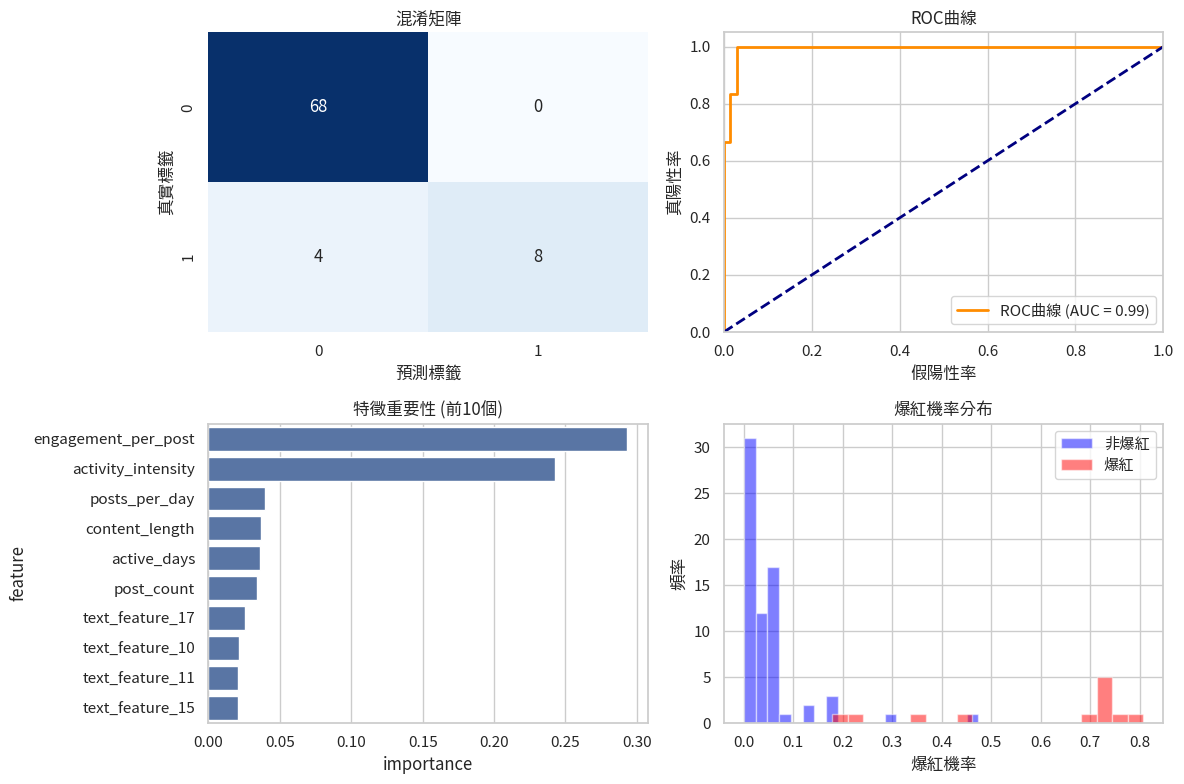


=== ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéáÈ†êÊ∏¨Á§∫‰æã ===
ÈÅ∏Âèñ 2 ÁØáÂØ¶ÈöõÁàÜÁ¥ÖÊñáÁ´†Âíå 1 ÁØáÈùûÁàÜÁ¥ÖÊñáÁ´†ÈÄ≤Ë°åÊ∏¨Ë©¶
Ê®°ÂûãÊúüÊúõÁöÑÁâπÂæµÊï∏Èáè: 29
ÁâπÂæµÂàóË°®: ['post_count', 'active_days', 'posts_per_day', 'activity_intensity', 'engagement_per_post', 'content_length', 'hashtag_count', 'text_feature_0', 'text_feature_1', 'text_feature_2']...

ÊñáÁ´† 1: ÂëäÂà• 2020 ÂØ¶üê≠‰∏çÊòì
ËøéÊé• 2021  üêÆËΩâ‰πæÂù§

ÊÑüË¨ù...
ÁàÜÁ¥ÖÊ©üÁéá: 52.90%
È†êÊ∏¨ÁµêÊûú: ÂèØËÉΩÁàÜÁ¥Ö

ÊñáÁ´† 2: 
‚ù§Ô∏è...
ÁàÜÁ¥ÖÊ©üÁéá: 63.64%
È†êÊ∏¨ÁµêÊûú: ÂèØËÉΩÁàÜÁ¥Ö

ÊñáÁ´† 3: ‰∏çËÉΩÂá∫ÂúãÁöÑJJ‰πüËø∑‰∏äÈú≤ÁáüÂï¶ (Ôæâ>œâ<)Ôæâ
üçé #ËòãÊûúÁç®ÂÆ∂ ...
ÁàÜÁ¥ÖÊ©üÁéá: 16.00%
È†êÊ∏¨ÁµêÊûú: ‰∏çÂ§™ÂèØËÉΩÁàÜÁ¥Ö
=== ÂàÜÊûêÂÆåÊàê ===
Ê≠§Ê®°ÂûãÂèØ‰ª•Âπ´Âä©:
1. È†êÊ∏¨ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéá
2. Ë≠òÂà•ÁàÜÁ¥ÖÈóúÈçµÂ≠ó
3. ÂÑ™ÂåñÂÖßÂÆπÁ≠ñÁï•
4. ÊèêÂçáÊñáÁ´†‰∫íÂãïÁéá


C:\Users\king2\AppData\Local\Temp\ipykernel_9676\821325399.py:53: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')
C:\Users\king2\AppData\Local\Temp\ipykernel_9676\821325399.py:53: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')
C:\Users\king2\AppData\Local\Temp\ipykernel_9676\821325399.py:53: FutureWarning: The behavior of 'to_datetime' w

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import jieba
from collections import Counter

# Ë®≠ÁΩÆ‰∏≠ÊñáÂ≠óÈ´î
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("=== ÊñáÁ´†ÁàÜÁ¥ÖÈ†êÊ∏¨ËàáÈóúÈçµÂ≠óÂàÜÊûêÊ®°Âûã ===\n")

# 1. ÊñáÊú¨È†êËôïÁêÜÂáΩÊï∏
def preprocess_text(text):
    """ÊñáÊú¨È†êËôïÁêÜÔºöÊ∏ÖÁêÜÂíåÂàÜË©û"""
    if pd.isna(text):
        return ""
    
    # ÁßªÈô§ÁâπÊÆäÁ¨¶ËôüÂíåÁ∂≤ÂùÄ
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[^\w\s#@]', ' ', text)
    
    # ‰ΩøÁî®jiebaÂàÜË©û
    words = jieba.cut(text)
    # ÈÅéÊøæÊéâÈï∑Â∫¶Â∞èÊñº2ÁöÑË©ûÂíåÂ∏∏Ë¶ãÂÅúÁî®Ë©û
    stop_words = {'ÁöÑ', '‰∫Ü', 'Âú®', 'ÊòØ', 'Êàë', 'Êúâ', 'Âíå', 'Â∞±', '‰∏ç', '‰∫∫', 'ÈÉΩ', '‰∏Ä', '‰∏ÄÂÄã', '‰∏ä', '‰πü', 'Âæà', 'Âà∞', 'Ë™™', 'Ë¶Å', 'Âéª', '‰Ω†', 'ÊúÉ', 'ÁùÄ', 'Ê≤íÊúâ', 'Áúã', 'Â•Ω', 'Ëá™Â∑±', 'ÈÄô'}
    words = [word for word in words if len(word) >= 2 and word not in stop_words]
    
    return ' '.join(words)

# 2. ÁâπÂæµÂ∑•Á®ã
def create_features(data):
    """ÂâµÂª∫È†êÊ∏¨ÁâπÂæµ"""
    # Âü∫Êú¨‰∫íÂãïÁâπÂæµ
    data['total_engagement'] = data['reaction_all'] + data['comment_count'] + data['share_count']
    data['posts_per_day'] = data['post_count'] / data['active_days']
    data['activity_intensity'] = data['total_engagement'] / data['active_days']
    data['engagement_per_post'] = data['total_engagement'] / data['post_count']
    
    # ÂÖßÂÆπÁâπÂæµ
    data['content_length'] = data['content'].fillna('').str.len()
    data['has_hashtag'] = data['content'].fillna('').str.contains('#').astype(int)
    data['hashtag_count'] = data['content'].fillna('').str.count('#')
    
    # ÊôÇÈñìÁâπÂæµÔºàÂæûcreated_timeÊèêÂèñÔºâ
    data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')
    data['hour'] = data['created_datetime'].dt.hour
    data['day_of_week'] = data['created_datetime'].dt.dayofweek
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    
    return data

# ‰ΩøÁî®Â∑≤Á∂ìËºâÂÖ•ÁöÑmerged_data
print("ËºâÂÖ•Êï∏Êìö‰∏¶ÈÄ≤Ë°åÁâπÂæµÂ∑•Á®ã...")

# Ê™¢Êü•Êï∏ÊìöÂü∫Êú¨‰ø°ÊÅØ
print(f"Êï∏ÊìöÂΩ¢ÁãÄ: {merged_data.shape}")
print(f"Ê¨Ñ‰Ωç: {list(merged_data.columns)}")
print("\nÊï∏ÊìöÂü∫Êú¨Áµ±Ë®à:")
print(merged_data[['reaction_all', 'comment_count', 'share_count', 'post_count', 'active_days']].describe())

# ÈÄ≤Ë°åÁâπÂæµÂ∑•Á®ã
merged_data = create_features(merged_data)

# Ê™¢Êü•ËôïÁêÜÂæåÁöÑÊï∏Êìö
print(f"\nÁâπÂæµÂ∑•Á®ãÂæåÊï∏ÊìöÂΩ¢ÁãÄ: {merged_data.shape}")
print(f"Êñ∞Â¢ûÁâπÂæµ: total_engagement, posts_per_day, activity_intensity, engagement_per_post, content_length, has_hashtag, hashtag_count")

# Ê™¢Êü•ÊòØÂê¶ÊúâÁ©∫ÂÄº‰∏¶ËôïÁêÜ
print(f"\nÊ™¢Êü•Á©∫ÂÄº:")
print(merged_data[['content', 'reaction_all', 'comment_count', 'share_count']].isnull().sum())

# ËôïÁêÜÁ©∫ÂÄº
merged_data['content'] = merged_data['content'].fillna('')
merged_data = merged_data.dropna(subset=['reaction_all', 'comment_count', 'share_count'])

# 3. ÊñáÊú¨ÁâπÂæµÊèêÂèñ
print("ÈÄ≤Ë°åÊñáÊú¨ÁâπÂæµÊèêÂèñ...")

# È†êËôïÁêÜÊñáÊú¨
merged_data['processed_content'] = merged_data['content'].apply(preprocess_text)

# ‰ΩøÁî®TF-IDFÊèêÂèñÊñáÊú¨ÁâπÂæµ
tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
text_features = tfidf.fit_transform(merged_data['processed_content'])

# ‰ΩøÁî®SVDÈôçÁ∂≠
svd = TruncatedSVD(n_components=20, random_state=42)
text_features_reduced = svd.fit_transform(text_features)

# Â∞áÊñáÊú¨ÁâπÂæµÊ∑ªÂä†Âà∞Êï∏ÊìöÊ°Ü
text_feature_names = [f'text_feature_{i}' for i in range(text_features_reduced.shape[1])]
text_df = pd.DataFrame(text_features_reduced, columns=text_feature_names)
merged_data = pd.concat([merged_data.reset_index(drop=True), text_df], axis=1)

# 4. ÂÆöÁæ©ÁàÜÁ¥ÖÊ®ôÊ∫ñ
threshold = merged_data['total_engagement'].quantile(0.85)  # Ââç15%ÁöÑ‰∫íÂãïÈáèË¢´Ë¶ñÁÇ∫ÁàÜÁ¥Ö
merged_data['is_viral'] = (merged_data['total_engagement'] >= threshold).astype(int)

print(f"\nÂ∞á‰∫íÂãïÁ∏ΩÈáèË∂ÖÈÅé {threshold:.2f} ÁöÑÊñáÁ´†ÂÆöÁæ©ÁÇ∫ÁàÜÁ¥Ö")
print(f"ÁàÜÁ¥ÖÊñáÁ´†Êï∏: {merged_data['is_viral'].sum()} (‰ΩîÊØî {merged_data['is_viral'].mean()*100:.2f}%)")

# Ê™¢Êü•ÁàÜÁ¥ÖÊñáÁ´†ÂàÜÂ∏É
print(f"\nÂêÑÈ†ÅÈù¢È°ûÂà•ÁöÑÁàÜÁ¥ÖÊñáÁ´†ÂàÜÂ∏É:")
viral_by_category = merged_data.groupby('page_category')['is_viral'].agg(['count', 'sum', 'mean'])
viral_by_category.columns = ['Á∏ΩÊï∏', 'ÁàÜÁ¥ÖÊï∏', 'ÁàÜÁ¥ÖÁéá']
viral_by_category['ÁàÜÁ¥ÖÁéá'] = viral_by_category['ÁàÜÁ¥ÖÁéá'] * 100
print(viral_by_category)

# 5. ÂàÜÊûêÁàÜÁ¥ÖËàáÈùûÁàÜÁ¥ÖÊñáÁ´†ÁöÑÁâπÂæµÂ∑ÆÁï∞
print("\nÁàÜÁ¥ÖËàáÈùûÁàÜÁ¥ÖÊñáÁ´†ÁöÑÁâπÂæµÂ∑ÆÁï∞:")
numerical_features = ['post_count', 'active_days', 'posts_per_day', 'activity_intensity', 
                     'engagement_per_post', 'content_length', 'hashtag_count']

for feature in numerical_features:
    viral_mean = merged_data[merged_data['is_viral'] == 1][feature].mean()
    non_viral_mean = merged_data[merged_data['is_viral'] == 0][feature].mean()
    diff_pct = ((viral_mean / non_viral_mean) - 1) * 100 if non_viral_mean != 0 else float('inf')
    print(f"{feature}: ÁàÜÁ¥Ö {viral_mean:.2f} vs ÈùûÁàÜÁ¥Ö {non_viral_mean:.2f} (Â∑ÆÁï∞ {diff_pct:.2f}%)")

# 6. ÈóúÈçµÂ≠óÂàÜÊûê
print("\n=== ÁàÜÁ¥ÖÊñáÁ´†ÈóúÈçµÂ≠óÂàÜÊûê ===")

# ÂàÜÊûêÁàÜÁ¥ÖÊñáÁ´†ÁöÑÈóúÈçµÂ≠ó
viral_content = merged_data[merged_data['is_viral'] == 1]['processed_content'].str.cat(sep=' ')
non_viral_content = merged_data[merged_data['is_viral'] == 0]['processed_content'].str.cat(sep=' ')

viral_words = viral_content.split()
non_viral_words = non_viral_content.split()

viral_word_freq = Counter(viral_words)
non_viral_word_freq = Counter(non_viral_words)

# ÊâæÂá∫ÁàÜÁ¥ÖÊñáÁ´†‰∏≠Âá∫ÁèæÈ†ªÁéáÈ´ò‰ΩÜÂú®ÈùûÁàÜÁ¥ÖÊñáÁ´†‰∏≠ËºÉÂ∞ëÁöÑÈóúÈçµÂ≠ó
viral_keywords = []
for word, freq in viral_word_freq.most_common(50):
    if len(word) >= 2:  # ÈÅéÊøæÂ§™Áü≠ÁöÑË©û
        viral_rate = freq / len(viral_words) if len(viral_words) > 0 else 0
        non_viral_rate = non_viral_word_freq.get(word, 0) / len(non_viral_words) if len(non_viral_words) > 0 else 0
        
        if viral_rate > non_viral_rate * 1.5:  # Âú®ÁàÜÁ¥ÖÊñáÁ´†‰∏≠Âá∫ÁèæÈ†ªÁéáËá≥Â∞ëÊòØÈùûÁàÜÁ¥ÖÁöÑ1.5ÂÄç
            viral_keywords.append((word, viral_rate, non_viral_rate, viral_rate/non_viral_rate if non_viral_rate > 0 else float('inf')))

# ÊåâÁÖßÊØîÁéáÊéíÂ∫è
viral_keywords.sort(key=lambda x: x[3], reverse=True)

print("ÁàÜÁ¥ÖÊñáÁ´†ÈóúÈçµÂ≠ó (Ââç10ÂÄã):")
for i, (word, viral_rate, non_viral_rate, ratio) in enumerate(viral_keywords[:10]):
    print(f"{i+1}. '{word}': ÁàÜÁ¥ÖÊñáÁ´†Âá∫ÁèæÁéá {viral_rate:.4f}, ÈùûÁàÜÁ¥Ö {non_viral_rate:.4f}, ÊØîÁéá {ratio:.2f}")

# 7. Âª∫Á´ãÈ†êÊ∏¨Ê®°Âûã
print("\n=== Âª∫Á´ãÈ†êÊ∏¨Ê®°Âûã ===")

# ÈÅ∏ÊìáÁâπÂæµ
feature_columns = numerical_features + text_feature_names + ['has_hashtag', 'is_weekend']

# Á¢∫‰øùÊâÄÊúâÁâπÂæµÂàóÈÉΩÂ≠òÂú®
missing_features = [col for col in feature_columns if col not in merged_data.columns]
if missing_features:
    print(f"Áº∫Â∞ëÁâπÂæµ: {missing_features}")
    # ÁÇ∫Áº∫Â∞ëÁöÑÁâπÂæµÊ∑ªÂä†ÈªòË™çÂÄº
    for feature in missing_features:
        if feature == 'is_weekend':
            merged_data[feature] = 0
        else:
            merged_data[feature] = 0

X = merged_data[feature_columns]
y = merged_data['is_viral']

print(f"ÊúÄÁµÇÁâπÂæµÁü©Èô£ÂΩ¢ÁãÄ: {X.shape}")
print(f"ÁâπÂæµÈ†ÜÂ∫è: {list(X.columns)}")

# ÂàÜÂâ≤Êï∏ÊìöÈõÜ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Âª∫Á´ãÈö®Ê©üÊ£ÆÊûóÊ®°Âûã
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# 8. Ê®°ÂûãË©ï‰º∞
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Ë®ìÁ∑¥ÈõÜÊ∫ñÁ¢∫Áéá: {train_accuracy:.4f}")
print(f"Ê∏¨Ë©¶ÈõÜÊ∫ñÁ¢∫Áéá: {test_accuracy:.4f}")
print("\nÂàÜÈ°ûÂ†±Âëä:")
print(classification_report(y_test, y_test_pred))

# 9. ÁâπÂæµÈáçË¶ÅÊÄßÂàÜÊûê
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nÁâπÂæµÈáçË¶ÅÊÄß (Ââç10ÂÄã):")
print(feature_importance.head(10))

# 10. Ë¶ñË¶∫Âåñ
plt.figure(figsize=(12, 8))

# Ê∑∑Ê∑ÜÁü©Èô£
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Ê∑∑Ê∑ÜÁü©Èô£')
plt.xlabel('È†êÊ∏¨Ê®ôÁ±§')
plt.ylabel('ÁúüÂØ¶Ê®ôÁ±§')

# ROCÊõ≤Á∑ö
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
test_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROCÊõ≤Á∑ö (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('ÂÅáÈôΩÊÄßÁéá')
plt.ylabel('ÁúüÈôΩÊÄßÁéá')
plt.title('ROCÊõ≤Á∑ö')
plt.legend(loc="lower right")

# ÁâπÂæµÈáçË¶ÅÊÄß
plt.subplot(2, 2, 3)
top_features = feature_importance.head(10)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('ÁâπÂæµÈáçË¶ÅÊÄß (Ââç10ÂÄã)')

# ÁàÜÁ¥ÖÊ©üÁéáÂàÜÂ∏É
plt.subplot(2, 2, 4)
plt.hist(y_test_proba[y_test == 0], bins=20, alpha=0.5, label='ÈùûÁàÜÁ¥Ö', color='blue')
plt.hist(y_test_proba[y_test == 1], bins=20, alpha=0.5, label='ÁàÜÁ¥Ö', color='red')
plt.xlabel('ÁàÜÁ¥ÖÊ©üÁéá')
plt.ylabel('È†ªÁéá')
plt.title('ÁàÜÁ¥ÖÊ©üÁéáÂàÜÂ∏É')
plt.legend()

plt.tight_layout()
plt.show()

# 11. ÂØ¶Áî®ÂáΩÊï∏ÔºöÈ†êÊ∏¨Êñ∞ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéá
def predict_viral_probability(content, post_count=20, active_days=60, page_category='News & Media Website'):
    """È†êÊ∏¨ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéá"""
    
    # È†êËôïÁêÜÂÖßÂÆπ
    processed_content = preprocess_text(content)
    
    # ÂâµÂª∫‰∏ÄÂÄãËá®ÊôÇDataFrame‰æÜÈÄ≤Ë°åÁâπÂæµÂ∑•Á®ã
    temp_data = pd.DataFrame({
        'cluster_id': [0],
        'created_time': [merged_data['created_time'].iloc[0]],  # ‰ΩøÁî®Á¨¨‰∏ÄÂÄãÊôÇÈñìÊà≥
        'reaction_all': [100],  # ÂÅáË®≠ÂÄº
        'comment_count': [100],  # ÂÅáË®≠ÂÄº
        'share_count': [100],    # ÂÅáË®≠ÂÄº
        'date': [merged_data['date'].iloc[0]],
        'page_category': [page_category],
        'page_name': ['È†êÊ∏¨Ê∏¨Ë©¶'],
        'content': [content],
        'first_date': [merged_data['first_date'].iloc[0]],
        'last_date': [merged_data['last_date'].iloc[0]],
        'post_count': [post_count],
        'active_days': [active_days]
    })
    
    # ÈÄ≤Ë°åÁâπÂæµÂ∑•Á®ã
    temp_data = create_features(temp_data)
    
    # ÊñáÊú¨ÁâπÂæµËôïÁêÜ
    temp_data['processed_content'] = temp_data['content'].apply(preprocess_text)
    text_vec = tfidf.transform(temp_data['processed_content'])
    text_features_new = svd.transform(text_vec)
    
    # Â∞áÊñáÊú¨ÁâπÂæµÊ∑ªÂä†Âà∞Ëá®ÊôÇÊï∏Êìö
    text_df = pd.DataFrame(text_features_new, columns=text_feature_names)
    temp_data = pd.concat([temp_data.reset_index(drop=True), text_df], axis=1)
    
    # Á¢∫‰øùÊâÄÊúâÂøÖË¶ÅÁöÑÁâπÂæµÈÉΩÂ≠òÂú®Ôºå‰∏¶ÊåâÁÖßË®ìÁ∑¥ÊôÇÁöÑÈ†ÜÂ∫è
    for feature in feature_columns:
        if feature not in temp_data.columns:
            if feature == 'is_weekend':
                temp_data[feature] = 0  # ÂÅáË®≠‰∏çÊòØÈÄ±Êú´
            else:
                temp_data[feature] = 0  # ÈªòË™çÂÄº
    
    # ÊåâÁÖßË®ìÁ∑¥ÊôÇÁöÑÁâπÂæµÈ†ÜÂ∫èÊèêÂèñÁâπÂæµ
    X_new = temp_data[feature_columns]
    
    # Á¢∫‰øùÁâπÂæµÈ†ÜÂ∫èÂíåÂêçÁ®±ÂÆåÂÖ®ÂåπÈÖç
    X_new = X_new.reindex(columns=X.columns, fill_value=0)
    
    # È†êÊ∏¨
    prob = rf_model.predict_proba(X_new)[0, 1]
    return prob

# 12. Á§∫‰æãÈ†êÊ∏¨
print("\n=== ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéáÈ†êÊ∏¨Á§∫‰æã ===")

# Âæû merged_data ‰∏≠ÈÅ∏ÂèñÂØ¶ÈöõÁöÑÊñáÁ´†Ê°à‰æã
viral_articles = merged_data[merged_data['is_viral'] == 1]['content'].dropna().sample(2, random_state=42)
non_viral_articles = merged_data[merged_data['is_viral'] == 0]['content'].dropna().sample(1, random_state=42)

test_articles = list(viral_articles) + list(non_viral_articles)

print(f"ÈÅ∏Âèñ {len(viral_articles)} ÁØáÂØ¶ÈöõÁàÜÁ¥ÖÊñáÁ´†Âíå {len(non_viral_articles)} ÁØáÈùûÁàÜÁ¥ÖÊñáÁ´†ÈÄ≤Ë°åÊ∏¨Ë©¶")

print(f"Ê®°ÂûãÊúüÊúõÁöÑÁâπÂæµÊï∏Èáè: {len(feature_columns)}")
print(f"ÁâπÂæµÂàóË°®: {feature_columns[:10]}...") # Âè™È°ØÁ§∫Ââç10ÂÄã

for i, article in enumerate(test_articles):
    try:
        prob = predict_viral_probability(article)
        print(f"\nÊñáÁ´† {i+1}: {article[:30]}...")
        print(f"ÁàÜÁ¥ÖÊ©üÁéá: {prob:.2%}")
        print(f"È†êÊ∏¨ÁµêÊûú: {'ÂèØËÉΩÁàÜÁ¥Ö' if prob >= 0.5 else '‰∏çÂ§™ÂèØËÉΩÁàÜÁ¥Ö'}")
    except Exception as e:
        print(f"ÊñáÁ´† {i+1} È†êÊ∏¨ÊôÇÁôºÁîüÈåØË™§: {e}")
        continue

print("=== ÂàÜÊûêÂÆåÊàê ===")
print("Ê≠§Ê®°ÂûãÂèØ‰ª•Âπ´Âä©:")
print("1. È†êÊ∏¨ÊñáÁ´†ÁàÜÁ¥ÖÊ©üÁéá")
print("2. Ë≠òÂà•ÁàÜÁ¥ÖÈóúÈçµÂ≠ó")
print("3. ÂÑ™ÂåñÂÖßÂÆπÁ≠ñÁï•")
print("4. ÊèêÂçáÊñáÁ´†‰∫íÂãïÁéá")

Âü∫ÊñºÊ≠£Ë¶èÂåñ‰∫íÂãïÈáèÊ¨äÈáçÁöÑÁÜ±ÈñÄÈóúÈçµÂ≠ó (Ââç20ÂÄã):
 1. 'Êñ∞ËÅû': Ê≠£Ë¶èÂåñÊ¨äÈáç 164.72, Âá∫ÁèæÊ¨°Êï∏ 93, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.610
 2. 'Âè∞ÁÅ£': Ê≠£Ë¶èÂåñÊ¨äÈáç 101.39, Âá∫ÁèæÊ¨°Êï∏ 46, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.759
 3. '2021': Ê≠£Ë¶èÂåñÊ¨äÈáç 79.57, Âá∫ÁèæÊ¨°Êï∏ 41, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.668
 4. 'ETtoday': Ê≠£Ë¶èÂåñÊ¨äÈáç 73.49, Âá∫ÁèæÊ¨°Êï∏ 30, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.843
 5. 'Á´ãÊñ∞': Ê≠£Ë¶èÂåñÊ¨äÈáç 67.88, Âá∫ÁèæÊ¨°Êï∏ 19, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 1.230
 6. 'ÊàëÂÄë': Ê≠£Ë¶èÂåñÊ¨äÈáç 63.45, Âá∫ÁèæÊ¨°Êï∏ 33, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.662
 7. 'Â§ßÂÆ∂': Ê≠£Ë¶èÂåñÊ¨äÈáç 60.48, Âá∫ÁèæÊ¨°Êï∏ 40, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.521
 8. 'ÁîüÊ¥ª': Ê≠£Ë¶èÂåñÊ¨äÈáç 58.79, Âá∫ÁèæÊ¨°Êï∏ 33, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.613
 9. 'ÁæéÂúã': Ê≠£Ë¶èÂåñÊ¨äÈáç 57.63, Âá∫ÁèæÊ¨°Êï∏ 25, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.794
10. 'Áñ´ÊÉÖ': Ê≠£Ë¶èÂåñÊ¨äÈáç 54.84, Âá∫ÁèæÊ¨°Êï∏ 34, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.555
11. 'ÁúüÁöÑ': Ê≠£Ë¶èÂåñÊ¨äÈáç 51.74, Âá∫ÁèæÊ¨°Êï∏ 37, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç 0.481
12. 'ËÅûÁ∂≤': Ê≠£Ë¶èÂåñÊ¨äÈáç 50.23, Âá∫ÁèæÊ¨°Êï∏ 19, Âπ≥Âùá‰∫íÂãïÊ¨ä

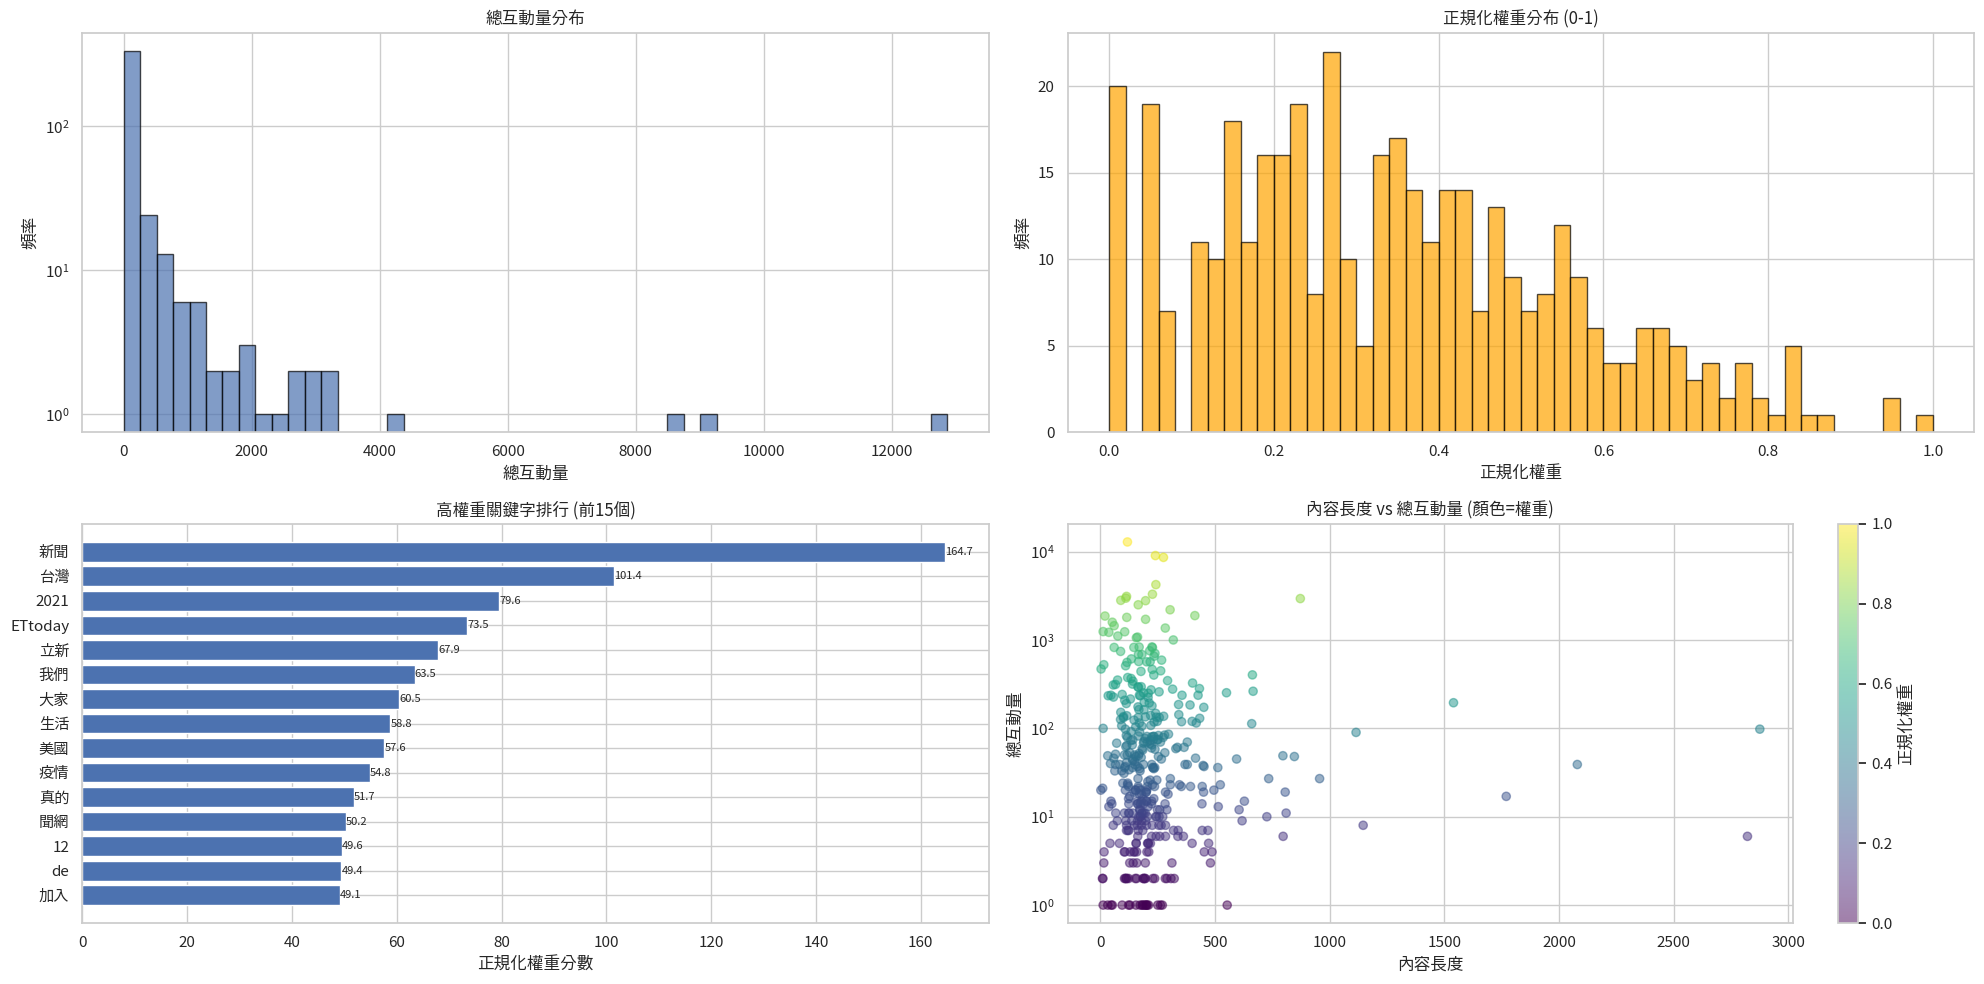


‚úÖ ÊîπÈÄ≤ÁöÑÂä†Ê¨äÈóúÈçµÂ≠óÂàÜÊûêÂÆåÊàê!
üìä ‰∏ªË¶ÅÊîπÈÄ≤:
   - Ê¨äÈáçÊ≠£Ë¶èÂåñËá≥ 0-1 ÁØÑÂúç
   - Â¢ûÂä†Ë©ûÈ†ªÁµ±Ë®àÔºåÊèê‰æõÊõ¥Áõ¥ËßÄÁöÑÊåáÊ®ô
   - ÊîπÈÄ≤ÁâπÊúâÈóúÈçµÂ≠óÁöÑÈáçË¶ÅÊÄßË®àÁÆó
   - Â¢ûÂº∑Ë¶ñË¶∫ÂåñÊïàÊûú

üìÅ Â∑≤‰øùÂ≠òÁµêÊûúËá≥:
   - normalized_weighted_keywords.csv (Ê≠£Ë¶èÂåñÊ¨äÈáçÈóúÈçµÂ≠ó)
   - improved_distinctive_keywords.csv (ÊîπÈÄ≤ÁöÑÁâπÊúâÈóúÈçµÂ≠ó)

üìà Áµ±Ë®àÊëòË¶Å:
   - Á∏ΩË©ûÂΩôÊï∏: 9406
   - Âπ≥ÂùáÊ≠£Ë¶èÂåñÊ¨äÈáç: 2.557
   - Ê¨äÈáçÊ®ôÊ∫ñÂ∑Æ: 4.665
   - È´ò‰∫íÂãïÁâπÊúâË©ûÂΩôÊï∏: 81


In [14]:
# Ë®àÁÆóÁ∏Ω‰∫íÂãïÈáè‰ΩúÁÇ∫Ê¨äÈáç
merged_data['total_engagement'] = merged_data['reaction_all'] + merged_data['comment_count'] + merged_data['share_count']

# Â∞ç total_engagement ÂÅöÂ∞çÊï∏ËΩâÊèõÈÅøÂÖçÊ•µÁ´ØÂÄºÂΩ±Èüø
merged_data['engagement_weight'] = np.log1p(merged_data['total_engagement'])

# Ê≠£Ë¶èÂåñÊ¨äÈáçÂà∞ 0-1 ÁØÑÂúç
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
merged_data['normalized_weight'] = scaler.fit_transform(merged_data[['engagement_weight']])

# ‰ΩøÁî®Ê≠£Ë¶èÂåñÊ¨äÈáçË™øÊï¥TF-IDFÁâπÂæµ
weighted_tfidf = text_features.multiply(merged_data['normalized_weight'].values[:, None])

# Âü∫ÊñºÊ≠£Ë¶èÂåñÊ¨äÈáçÁöÑÈóúÈçµÂ≠óÂàÜÊûê
from collections import Counter
weighted_counter = Counter()
total_weight = 0
for idx, row in merged_data.iterrows():
    words = row['processed_content'].split()
    weight = row['normalized_weight']
    total_weight += weight
    for word in words:
        weighted_counter[word] += weight

# Ë®àÁÆóÂπ≥ÂùáÊ¨äÈáç‰∏¶Ê≠£Ë¶èÂåñÂàÜÊï∏
avg_weight = total_weight / len(merged_data)
normalized_counter = Counter()
for word, weight in weighted_counter.items():
    normalized_counter[word] = weight / avg_weight

# ÂèñÂâç40ÂÄãÈ´òÊ¨äÈáçÈóúÈçµÂ≠ó
print("Âü∫ÊñºÊ≠£Ë¶èÂåñ‰∫íÂãïÈáèÊ¨äÈáçÁöÑÁÜ±ÈñÄÈóúÈçµÂ≠ó (Ââç20ÂÄã):")
for i, (word, norm_weight) in enumerate(normalized_counter.most_common(20), 1):
    # Ë®àÁÆóË©ûÈ†ª
    word_freq = sum(1 for row in merged_data.itertuples() if word in row.processed_content.split())
    avg_engagement = weighted_counter[word] / word_freq if word_freq > 0 else 0
    print(f"{i:2d}. '{word}': Ê≠£Ë¶èÂåñÊ¨äÈáç {norm_weight:.2f}, Âá∫ÁèæÊ¨°Êï∏ {word_freq}, Âπ≥Âùá‰∫íÂãïÊ¨äÈáç {avg_engagement:.3f}")

# ÂàÜÊûêÈ´ò‰∫íÂãïËàá‰Ωé‰∫íÂãïÂÖßÂÆπÁöÑÈóúÈçµÂ≠óÂ∑ÆÁï∞
high_engagement_threshold = merged_data['total_engagement'].quantile(0.75)
low_engagement_threshold = merged_data['total_engagement'].quantile(0.25)

high_engagement_content = merged_data[merged_data['total_engagement'] >= high_engagement_threshold]['processed_content'].str.cat(sep=' ')
low_engagement_content = merged_data[merged_data['total_engagement'] <= low_engagement_threshold]['processed_content'].str.cat(sep=' ')

high_words = Counter(high_engagement_content.split())
low_words = Counter(low_engagement_content.split())

# ÊâæÂá∫Âú®È´ò‰∫íÂãïÂÖßÂÆπ‰∏≠Êõ¥Â∏∏Âá∫ÁèæÁöÑÈóúÈçµÂ≠ó
distinctive_keywords = []
for word, high_freq in high_words.most_common(100):
    if len(word) >= 2:
        low_freq = low_words.get(word, 0)
        if high_freq > low_freq * 1.5:  # Èôç‰ΩéÈñæÂÄºËÆìÁµêÊûúÊõ¥Ë±êÂØå5:
            ratio = high_freq / max(low_freq, 1)
            # Ë®àÁÆóÁõ∏Â∞çÈáçË¶ÅÊÄß
            total_high = sum(high_words.values())
            total_low = sum(low_words.values())
            relative_importance = (high_freq/total_high) / max((low_freq/total_low), 0.001)
            distinctive_keywords.append((word, high_freq, low_freq, ratio, relative_importance))

distinctive_keywords.sort(key=lambda x: x[4], reverse=True)  # ÊåâÁõ∏Â∞çÈáçË¶ÅÊÄßÊéíÂ∫èsort(key=lambda x: x[4], reverse=True)

print(f"\nÈ´ò‰∫íÂãïÂÖßÂÆπÁâπÊúâÈóúÈçµÂ≠ó (Ââç15ÂÄã):")
for i, (word, high_freq, low_freq, ratio, importance) in enumerate(distinctive_keywords[:15], 1):
    print(f"{i:2d}. '{word}': È´ò‰∫íÂãï {high_freq} vs ‰Ωé‰∫íÂãï {low_freq}, ÂÄçÊï∏ {ratio:.1f}, ÈáçË¶ÅÊÄß {importance:.2f}")

# ÂâµÂª∫Âä†Ê¨äÁöÑË©ûÂΩôÈáçË¶ÅÊÄßÂàÜÊï∏ÂΩôÈáçË¶ÅÊÄßÂàÜÊï∏ÂΩôÈáçË¶ÅÊÄßÂàÜÊï∏
def calculate_weighted_word_importance(word, tfidf_vectorizer, weighted_tfidf_matrix):
    """Ë®àÁÆóË©ûÂΩôÁöÑÂä†Ê¨äÈáçË¶ÅÊÄßÂàÜÊï∏"""
    try:
        word_idx = tfidf_vectorizer.vocabulary_.get(word)
        if word_idx is not None:
            # Ë®àÁÆóË©≤Ë©ûÂú®ÊâÄÊúâÊñáÊ™î‰∏≠ÁöÑÂä†Ê¨äTF-IDFÂπ≥ÂùáÂÄº
            word_scores = weighted_tfidf_matrix[:, word_idx].toarray().flatten()
            return np.mean(word_scores[word_scores > 0])
        return 0
    except:
        return 0

# Ë®àÁÆóTF-IDFË©ûÂΩôË°®‰∏≠ÊØèÂÄãË©ûÁöÑÂä†Ê¨äÈáçË¶ÅÊÄßÊ¨äÈáçË¶ÅÊÄßÊ¨äÈáçË¶ÅÊÄß
vocab_importance = {}
for word in tfidf.vocabulary_:
    importance = calculate_weighted_word_importance(word, tfidf, weighted_tfidf)
    if importance > 0:
        vocab_importance[word] = importance

# ÊåâÈáçË¶ÅÊÄßÊéíÂ∫è‰∏¶Ê≠£Ë¶èÂåñ
if vocab_importance:
    max_importance = max(vocab_importance.values())
    vocab_importance = {word: (score/max_importance)*100 for word, score in vocab_importance.items()}
    sorted_vocab = sorted(vocab_importance.items(), key=lambda x: x[1], reverse=True)

    print(f"\nTF-IDFÂä†Ê¨äÈáçË¶ÅÊÄßË©ûÂΩô (Ââç15ÂÄã):")
    for i, (word, importance) in enumerate(sorted_vocab[:15], 1):
        print(f"{i:2d}. '{word}': ÈáçË¶ÅÊÄßÂàÜÊï∏ {importance:.1f}/100")

# Ë¶ñË¶∫ÂåñÊ¨äÈáçÂàÜÂ∏É
plt.figure(figsize=(20, 10))

# ‰∫íÂãïÈáèÂàÜÂ∏É
plt.subplot(2, 2, 1)
plt.hist(merged_data['total_engagement'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Á∏Ω‰∫íÂãïÈáèÂàÜÂ∏É')
plt.xlabel('Á∏Ω‰∫íÂãïÈáè')
plt.ylabel('È†ªÁéá')
plt.yscale('log')

# Ê≠£Ë¶èÂåñÊ¨äÈáçÂàÜÂ∏É
plt.subplot(2, 2, 2)
plt.hist(merged_data['normalized_weight'], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Ê≠£Ë¶èÂåñÊ¨äÈáçÂàÜÂ∏É (0-1)')
plt.xlabel('Ê≠£Ë¶èÂåñÊ¨äÈáç')
plt.ylabel('È†ªÁéá')

# È´òÊ¨äÈáçÈóúÈçµÂ≠óÊ¢ùÂΩ¢Âúñ
plt.subplot(2, 2, 3)
top_normalized_words = [item[0] for item in normalized_counter.most_common(15)]
top_normalized_scores = [item[1] for item in normalized_counter.most_common(15)]
y_pos = np.arange(len(top_normalized_words))
bars = plt.barh(y_pos, top_normalized_scores)
plt.yticks(y_pos, top_normalized_words)
plt.xlabel('Ê≠£Ë¶èÂåñÊ¨äÈáçÂàÜÊï∏')
plt.title('È´òÊ¨äÈáçÈóúÈçµÂ≠óÊéíË°å (Ââç15ÂÄã)')
plt.gca().invert_yaxis()

# ÁÇ∫Ê¢ùÂΩ¢ÂúñÊ∑ªÂä†Êï∏ÂÄºÊ®ôÁ±§
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', ha='left', va='center', fontsize=8)

# ‰∫íÂãïÈáèËàáÂÖßÂÆπÈï∑Â∫¶Èóú‰øÇ
plt.subplot(2, 2, 4)
plt.scatter(merged_data['content_length'], merged_data['total_engagement'], 
           alpha=0.5, c=merged_data['normalized_weight'], cmap='viridis')
plt.xlabel('ÂÖßÂÆπÈï∑Â∫¶')
plt.ylabel('Á∏Ω‰∫íÂãïÈáè')
plt.title('ÂÖßÂÆπÈï∑Â∫¶ vs Á∏Ω‰∫íÂãïÈáè (È°èËâ≤=Ê¨äÈáç)')
plt.yscale('log')
plt.colorbar(label='Ê≠£Ë¶èÂåñÊ¨äÈáç')

plt.tight_layout()
plt.show()

# ‰øùÂ≠òÊîπÈÄ≤ÁöÑÁµêÊûú
# Ê≠£Ë¶èÂåñÊ¨äÈáçÈóúÈçµÂ≠ó
normalized_keywords_df = pd.DataFrame([
    {
        'ÈóúÈçµÂ≠ó': word, 
        'Ê≠£Ë¶èÂåñÊ¨äÈáç': weight,
        'Âá∫ÁèæÊ¨°Êï∏': sum(1 for row in merged_data.itertuples() if word in row.processed_content.split()),
        'Âπ≥Âùá‰∫íÂãïÊ¨äÈáç': weighted_counter[word] / sum(1 for row in merged_data.itertuples() if word in row.processed_content.split())
    }
    for word, weight in normalized_counter.most_common(50)
])

# ÊîπÈÄ≤ÁöÑÁâπÊúâÈóúÈçµÂ≠ó
improved_distinctive_df = pd.DataFrame(distinctive_keywords[:30], 
                                     columns=['ÈóúÈçµÂ≠ó', 'È´ò‰∫íÂãïÈ†ªÁéá', '‰Ωé‰∫íÂãïÈ†ªÁéá', 'È†ªÁéáÊØîÁéá', 'Áõ∏Â∞çÈáçË¶ÅÊÄß'])

# ‰øùÂ≠òÊ™îÊ°à
normalized_keywords_df.to_csv('normalized_weighted_keywords.csv', index=False, encoding='utf-8')
improved_distinctive_df.to_csv('improved_distinctive_keywords.csv', index=False, encoding='utf-8')

print(f"\n‚úÖ ÊîπÈÄ≤ÁöÑÂä†Ê¨äÈóúÈçµÂ≠óÂàÜÊûêÂÆåÊàê!")
print(f"üìä ‰∏ªË¶ÅÊîπÈÄ≤:")
print(f"   - Ê¨äÈáçÊ≠£Ë¶èÂåñËá≥ 0-1 ÁØÑÂúç")
print(f"   - Â¢ûÂä†Ë©ûÈ†ªÁµ±Ë®àÔºåÊèê‰æõÊõ¥Áõ¥ËßÄÁöÑÊåáÊ®ô")
print(f"   - ÊîπÈÄ≤ÁâπÊúâÈóúÈçµÂ≠óÁöÑÈáçË¶ÅÊÄßË®àÁÆó")
print(f"   - Â¢ûÂº∑Ë¶ñË¶∫ÂåñÊïàÊûú")
print(f"\nüìÅ Â∑≤‰øùÂ≠òÁµêÊûúËá≥:")
print(f"   - normalized_weighted_keywords.csv (Ê≠£Ë¶èÂåñÊ¨äÈáçÈóúÈçµÂ≠ó)")
print(f"   - improved_distinctive_keywords.csv (ÊîπÈÄ≤ÁöÑÁâπÊúâÈóúÈçµÂ≠ó)")

# Ëº∏Âá∫Áµ±Ë®àÊëòË¶Å
print(f"\nüìà Áµ±Ë®àÊëòË¶Å:")
print(f"   - Á∏ΩË©ûÂΩôÊï∏: {len(weighted_counter)}")
print(f"   - Âπ≥ÂùáÊ≠£Ë¶èÂåñÊ¨äÈáç: {np.mean(list(normalized_counter.values())):.3f}")
print(f"   - Ê¨äÈáçÊ®ôÊ∫ñÂ∑Æ: {np.std(list(normalized_counter.values())):.3f}")
print(f"   - È´ò‰∫íÂãïÁâπÊúâË©ûÂΩôÊï∏: {len(distinctive_keywords)}")

In [60]:
# ÈáãÊîæ Milvus Ë≥áÊ∫ê
try:
    news_posts.release()
    cluster_centroids.release()
    print("ÊàêÂäüÈáãÊîæ Milvus ÈõÜÂêàË≥áÊ∫ê")
    
    # Êñ∑ÈñãËàá Milvus ÁöÑÈÄ£Êé•
    connections.disconnect("default")
    print("ÊàêÂäüÊñ∑Èñã Milvus ÈÄ£Êé•")
except Exception as e:
    print(f"ÈáãÊîæË≥áÊ∫êÊôÇÂá∫ÈåØ: {e}")

ÊàêÂäüÈáãÊîæ Milvus ÈõÜÂêàË≥áÊ∫ê
ÊàêÂäüÊñ∑Èñã Milvus ÈÄ£Êé•
